
# Protein Bar Comments — Desire & Gap Analysis (Multilingual)

**Objective:** Analyze ~13,000+ multilingual, unstructured comments to extract what people *want* from protein bar products in India, cluster themes/topics, gauge sentiment, and surface **gaps** (high-demand, low-satisfaction features or needs).

**What this notebook does:**
1. **Load & clean** your Excel (auto-detects file by name pattern).
2. **Language-aware pipeline** for multilingual text (no translation required, uses multilingual embeddings).
3. **Desire extraction** via multilingual keyword patterns + keyphrase extraction (YAKE).
4. **Topic modeling** using Sentence-Transformer embeddings → UMAP/HDBSCAN via **BERTopic** *(recommended)* or **KMeans** *(fallback)*.
5. **Sentiment** using a multilingual model (mBERT-based).
6. **Prioritization** of gaps: (mentions × negative/neutral sentiment × intensity of desire).
7. **Exports** clean datasets and summaries (CSV) for downstream use.

> You can run end-to-end with **BERTopic** (best quality) or switch to **KMeans** if you prefer fewer dependencies.
> Comments are never sent to an external API in this template. Models are downloaded from open sources when first run.



## 0. Quick Start

- Place your Excel file in the same folder as this notebook (or update `INPUT_PATH` below).
- If you're on a fresh environment, run the **Install** cell once.
- Then run cells top → bottom.

> This pipeline avoids heavy translation by using **multilingual models**. Translation (optional) is included for your convenience if you want English-only reports.


In [1]:

# === (Run once) Install dependencies ===
# If you already have these, you can skip.
# On some environments (e.g., Colab/VS Code), uncomment the line below.
%pip install --upgrade pandas openpyxl numpy matplotlib tqdm langdetect unidecode regex \
                sentence-transformers umap-learn hdbscan bertopic keybert yake \
                transformers torch scipy scikit-learn

# Optional: spaCy multilingual pipeline (for advanced NLP tasks)
# %pip install spacy
# !python -m spacy download xx_sent_ud_sm
# !python -m spacy download xx_ent_wiki_sm


  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached matplotlib-3.10.6-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached langdetect-1.0.9-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 20.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached torch-2.8.0-cp313-none-macosx_11_0_arm64.whl.metadata (30 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached PyYAML-6.0.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)
  Using cached rich-14.1.0-py3-none-any.whl.metadata (18 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached sympy-1.14.0-


## 1. Configuration
- The loader will try to find a file starting with `protein_comments_filtered_excel` automatically.
- If your filename is different, set `INPUT_PATH` manually.
- `TEXT_COLS` defines which columns may contain comment text (the first found will be used).


In [5]:
from pathlib import Path
import glob


INPUT_PATH = r"/Users/anubhav_77_/Desktop/yt_scraper/protein_comments_filtered.csv"
SHEET_NAME = None  # set to sheet name/index if needed, else None

# Columns that might contain comment text — the first present will be used
TEXT_COLS =  ["text"]

# Runtime toggles
USE_BERTOPIC = True    # Set False to use KMeans fallback
MAX_ROWS = None        # e.g., 20000 to cap for speed during tests; None = use all
BATCH_SIZE = 256       # embedding batch size
RANDOM_STATE = 42


print("Using INPUT_PATH:", INPUT_PATH)

Using INPUT_PATH: /Users/anubhav_77_/Desktop/yt_scraper/protein_comments_filtered.csv



## 2. Load & Clean Data
- Reads Excel via `pandas.read_excel`.
- Picks the first available text column from `TEXT_COLS`.
- Cleans text: normalize whitespace, strip urls/mentions, keep non-Latin scripts.


In [6]:
import pandas as pd
import re
from unidecode import unidecode
import os

def read_comments(path, sheet_name=None, text_cols=None, max_rows=None):
    file_ext = os.path.splitext(path)[1].lower()
    
    if file_ext == '.csv':
        df = pd.read_csv(path)
    elif file_ext in ['.xlsx', '.xls']:
        df = pd.read_excel(path, sheet_name=sheet_name, engine="openpyxl")
        if isinstance(df, dict):  # Multiple sheets
            # pick the first sheet by default
            df = list(df.values())[0]
    else:
        raise ValueError(f"Unsupported file extension: {file_ext}. Use CSV or Excel files.")
    
    # Auto-pick text column
    chosen_col = None
    for c in (text_cols or []):
        if c in df.columns:
            chosen_col = c
            break
    if chosen_col is None:
        # last resort: try first object column
        obj_cols = [c for c in df.columns if df[c].dtype == 'O']
        chosen_col = obj_cols[0] if obj_cols else df.columns[0]
        print(f"[WARN] None of {text_cols} found. Using '{chosen_col}'")
    # Subset + rename
    df = df[[chosen_col]].rename(columns={chosen_col: "text"})
    if max_rows:
        df = df.head(max_rows)
    return df

URL_RE = re.compile(r"https?://\S+|www\.\S+")
AT_RE  = re.compile(r"@\w+")
WS_RE  = re.compile(r"\s+")

def basic_clean(s):
    if not isinstance(s, str):
        s = str(s) if s is not None else ""
    s = s.strip()
    s = URL_RE.sub(" ", s)
    s = AT_RE.sub(" ", s)
    s = s.replace("\u200b", " ")  # zero-width space
    s = WS_RE.sub(" ", s)
    return s

df = read_comments(INPUT_PATH, sheet_name=SHEET_NAME, text_cols=TEXT_COLS, max_rows=MAX_ROWS)
df["text"] = df["text"].astype(str).map(basic_clean)
df = df[~df["text"].str.strip().eq("")].drop_duplicates(subset=["text"]).reset_index(drop=True)
print(df.shape)
df.head()

(10970, 1)


,text
0,Protein bar is also fake...its not proper prot...
1,"I have tried Yoga bar and Whole truth,"
2,It’s easy to make guys just take the nuts and ...
3,Read ingredient and nutition details on the pa...
4,Great point 💯



## 3. Language Detection (lightweight)

We use `langdetect` as a lightweight detector. It’s not perfect for short text, but works reasonably well.
You can later switch to fastText/CLD3 if you prefer.


In [7]:

from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

DetectorFactory.seed = 0

def detect_lang_safe(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

df["lang"] = df["text"].map(detect_lang_safe)
df["lang"].value_counts().head(20)


lang
en         6312
id         1110
so          514
sw          345
et          236
tl          226
unknown     204
af          202
de          161
hi          120
fi          113
no          110
ro          103
nl          103
fr           98
it           94
tr           89
cy           86
ca           70
da           68
Name: count, dtype: int64


## 4. Desire Intent — Multilingual Keyword Heuristics

We flag comments that express **wants/needs/requests** using multilingual patterns.
This is *recall-oriented*; it will over-flag sometimes, which is fine for discovery.

**Supported (examples):**
- **English:** want, need, wish, please add, missing, should have, request, would love, looking for
- **Hindi/Urdu (Devanagari/Arabic):** चाहता/चाहती/चाहिए, ज़रूरत/जरूरत, कृपया, जोड़ो/ऐड करो, कमी, चाहिए था/होना चाहिए, درکار، چاہیے، براہ کرم
- **Bengali:** চাই, প্রয়োজন, অনুরোধ, দয়া করে
- **Tamil:** வேண்டும், தேவை, தயவு செய்து
- **Telugu:** కావాలి, అవసరం, దయచేసి
- **Marathi:** हवे, गरज, कृपया, जोडा
- **Gujarati:** જોઈએ, જરૂર, કૃપા કરીને, ઉમેરો
- **Kannada:** ಬೇಕು, ಅಗತ್ಯ, ದಯವಿಟ್ಟು
- **Malayalam:** വേണം, ആവശ്യമാണ്, ദയവായി
- **Punjabi (Gurmukhi/Shahmukhi):** ਚਾਹੀਦਾ, ਲੋੜ, ਕਿਰਪਾ ਕਰਕੇ / چاہیدا، لوڑ

> You can expand this list easily below.


In [8]:
import regex as re

DESIRE_PATTERNS = [
    # English
    r"\b(want|needs?|wish(?:es)?|please\s+add|missing|should\s+have|request|would\s+love|looking\s+for|add\s+this|must\s+have)\b",
    # Hindi/Urdu (Devanagari/Arabic)
    r"(चाहता|चाहती|चाहिए|जरूरत|ज़रूरत|कृपया|जोड़ो|जोड़ो|ऐड\s*करो|कमी|होना\s*चाहिए)",
    r"(درکار|چاہیے|براہ\s*کرم)",
    # Hinglish (Hindi-English mixed)
    r"\b(chahiye|zaroorat|zarurat|kripya|kripaya|kammi|hona\s*chahiye|add\s*karo|jodho|plz\s*add|bhut\s*jaruri)\b",
    # Bengali
    r"(চাই|প্রয়োজন|অনুরোধ|দয়া\s*করে)",
    # Tamil
    r"(வேண்டும்|தேவை|தயவு\s*செய்து)",
    # Telugu
    r"(కావాలి|అవసరం|దయచేసి)",
    # Marathi
    r"(हवे|गरज|कृपया|जोडा)",
    # Gujarati
    r"(જોઈએ|જરૂર|કૃપા\s*કરીને|ઉમેરો)",
    # Kannada
    r"(ಬೇಕು|ಅಗತ್ಯ|ದಯವಿಟ್ಟು)",
    # Malayalam
    r"(വേണം|ആവശ്യമാണ്|ദയവായി)",
    # Punjabi (Gurmukhi/Shahmukhi)
    r"(ਚਾਹੀਦਾ|ਲੋੜ|ਕਿਰਪਾ\s*ਕਰਕੇ|چاہیدا|لوڑ)",
]

DESIRE_RE = re.compile("|".join(DESIRE_PATTERNS), flags=re.IGNORECASE)

def flag_desire(text):
    m = DESIRE_RE.search(text)
    return bool(m), (m.group(0) if m else "")

df["is_desire"], df["desire_hit"] = zip(*df["text"].map(flag_desire))
df["is_desire"].value_counts()

is_desire
False    10642
True       328
Name: count, dtype: int64


## 5. Keyphrase Extraction (YAKE)

We extract keyphrases per comment (especially for desire-flagged ones) to surface **what** users are asking for (e.g., *less sugar*, *bigger size*, *vegan option*, *better taste*, etc.).


In [9]:

import yake

# YAKE works across many languages; we keep it simple
kw_extractor = yake.KeywordExtractor(n=1, top=10)  # unigrams by default; adjust n-gram size as needed

def top_kps(text, topk=5):
    try:
        kw = kw_extractor.extract_keywords(text)
        # kw is list of (keyphrase, score), lower score = more important
        return [k for k, s in sorted(kw, key=lambda x: x[1])[:topk]]
    except Exception:
        return []

df["keyphrases"] = df["text"].map(lambda s: top_kps(s, topk=5))
df.head()


,text,lang,is_desire,desire_hit,keyphrases
0,Protein bar is also fake...its not proper prot...,en,False,,"[Protein, fake, bar, protin., proper]"
1,"I have tried Yoga bar and Whole truth,",en,False,,"[Yoga, truth, bar]"
2,It’s easy to make guys just take the nuts and ...,en,False,,"[easy, make, guys, nuts, oats]"
3,Read ingredient and nutition details on the pa...,en,True,want,"[Read, pack, ingredient, nutition, details]"
4,Great point 💯,en,False,,"[Great, point]"



## 6. Multilingual Embeddings

We use `sentence-transformers` (**paraphrase-multilingual-MiniLM-L12-v2**) to embed comments into a shared semantic space (supports 50+ languages). This lets us cluster without translating.


In [10]:

from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm import tqdm

model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

def embed_texts(texts, batch_size=256):
    vecs = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        emb = model.encode(batch, batch_size=batch_size, show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=True)
        vecs.append(emb)
    return np.vstack(vecs)

embeddings = embed_texts(df["text"].tolist(), batch_size=BATCH_SIZE)
embeddings.shape


100%|██████████| 43/43 [01:54<00:00,  2.66s/it]



(10970, 384)


## 7. Topic Modeling

**Option A (recommended):** [BERTopic](https://maartengr.github.io/BERTopic/) using UMAP + HDBSCAN for dense clusters and automatic topic labeling.  
**Option B (fallback):** KMeans with silhouette-based `k` selection.

Toggle with `USE_BERTOPIC` in the config cell.


In [11]:

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def kmeans_topics(emb, k_min=8, k_max=40, step=4, random_state=42):
    best_k, best_score = None, -1
    best_labels = None
    for k in range(k_min, k_max+1, step):
        km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        labels = km.fit_predict(emb)
        try:
            score = silhouette_score(emb, labels)
        except Exception:
            score = -1
        if score > best_score:
            best_k, best_score, best_labels = k, score, labels
    return best_k, best_score, best_labels

topic_labels = None

if USE_BERTOPIC:
    from bertopic import BERTopic
    import umap
    import hdbscan

    # UMAP for dimensionality reduction (speeds clustering)
    umap_model = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=RANDOM_STATE)
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=30, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

    topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, calculate_probabilities=True, verbose=False)
    topics, probs = topic_model.fit_transform(df["text"].tolist(), embeddings=embeddings)

    df["topic_id"] = topics
    # Generate human-readable labels
    topic_info = topic_model.get_topic_info()
    topic_labels = dict(zip(topic_info["Topic"], topic_info["Name"]))
    df["topic_label"] = df["topic_id"].map(topic_labels)
else:
    k, sil, labels = kmeans_topics(embeddings, k_min=12, k_max=48, step=4, random_state=RANDOM_STATE)
    print(f"[KMeans] best_k={k}, silhouette={sil:.4f}")
    df["topic_id"] = labels
    # Simple label: TF-IDF top terms for each cluster
    from sklearn.feature_extraction.text import TfidfVectorizer

    vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X = vec.fit_transform(df["text"].values)
    terms = np.array(vec.get_feature_names_out())

    topic_labels = {}
    for t in sorted(df["topic_id"].unique()):
        idx = np.where(df["topic_id"].values == t)[0]
        if len(idx) == 0: 
            topic_labels[t] = f"topic_{t}"
            continue
        centroid = X[idx].sum(axis=0)
        top_idx = np.argsort(centroid.A1)[-5:][::-1]
        label = ", ".join(terms[top_idx])
        topic_labels[t] = label
    df["topic_label"] = df["topic_id"].map(topic_labels)



## 8. Sentiment (Multilingual)

We use a multilingual sentiment model (`nlptown/bert-base-multilingual-uncased-sentiment`) that returns 1–5 stars.
We map to a continuous sentiment score in `[-1, +1]` for convenience.


In [12]:

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

SENT_MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(SENT_MODEL_NAME)
sent_model = AutoModelForSequenceClassification.from_pretrained(SENT_MODEL_NAME)

def sentiment_score(texts, batch_size=64, max_length=256):
    scores = []
    sent_model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            toks = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
            logits = sent_model(**toks).logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()  # shape: (B, 5)
            # Expected star rating (1..5)
            stars = (probs * np.arange(1,6)).sum(axis=1)
            # Map 1..5 → -1..+1
            s = (stars - 3.0) / 2.0
            scores.extend(s.tolist())
    return np.array(scores)

df["sentiment"] = sentiment_score(df["text"].tolist(), batch_size=64)
df["sentiment"].describe()


count    10970.000000
mean        -0.052765
std          0.459520
min         -0.991337
25%         -0.412198
50%         -0.124803
75%          0.295382
max          0.982763
Name: sentiment, dtype: float64


## 9. Aggregate Desires & Surface Gaps

We compute a simple **Gap Score** for each topic and desire keyphrase:
- `gap_score = mentions × max(0, 0.5 - avg_sentiment)`  
  (high mentions with low sentiment rank higher)
- You can tweak weights below.


In [12]:

import pandas as pd
import numpy as np
from collections import Counter

# Expand keyphrases into rows for desire-flagged comments
df_desire = df[df["is_desire"]].copy()
df_desire = df_desire.explode("keyphrases")
df_desire["keyphrases"] = df_desire["keyphrases"].fillna("").str.strip()
df_desire = df_desire[df_desire["keyphrases"] != ""]

agg = (df_desire
       .groupby(["topic_id", "topic_label", "keyphrases"], dropna=False)
       .agg(n=("text", "count"), avg_sent=("sentiment", "mean"))
       .reset_index())

# Gap score definition
def gap_score(n, avg_sent, base=0.5):
    return n * max(0.0, (base - (avg_sent if pd.notnull(avg_sent) else 0.0)))

agg["gap_score"] = agg.apply(lambda r: gap_score(r["n"], r["avg_sent"], base=0.5), axis=1)

# Top gaps per topic
top_gaps = (agg.sort_values(["topic_id", "gap_score"], ascending=[True, False])
               .groupby("topic_id")
               .head(10)
               .reset_index(drop=True))

print("Top gaps preview:")
top_gaps.head(20)


Top gaps preview:


,topic_id,topic_label,keyphrases,n,avg_sent,gap_score
0,-1,-1_good_so_and_the,protein,20,-0.150135,13.002704
1,-1,-1_good_so_and_the,chahiye,7,-0.219766,5.038364
2,-1,-1_good_so_and_the,grams,3,-0.489182,2.967547
3,-1,-1_good_so_and_the,good,6,0.011460,2.931242
4,-1,-1_good_so_and_the,dont,3,-0.392647,2.677940
5,-1,-1_good_so_and_the,source,3,-0.388324,2.664973
6,-1,-1_good_so_and_the,bar,3,-0.302224,2.406672
7,-1,-1_good_so_and_the,give,3,-0.300381,2.401142
8,-1,-1_good_so_and_the,eat,3,-0.281774,2.345322
9,-1,-1_good_so_and_the,calories,4,-0.082993,2.331972



## 10. Visualizations (matplotlib)

- Top topics by volume
- Top desire keyphrases by **Gap Score**


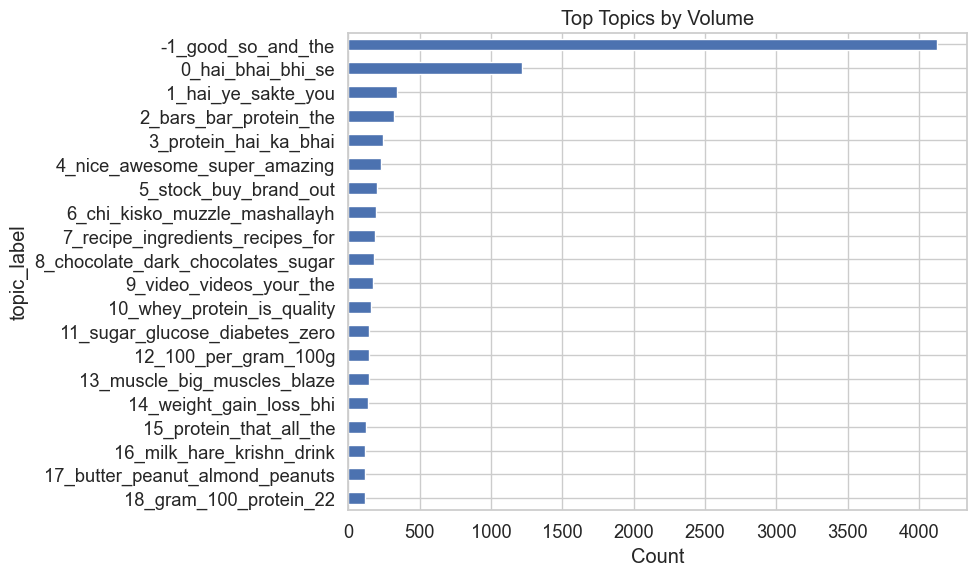

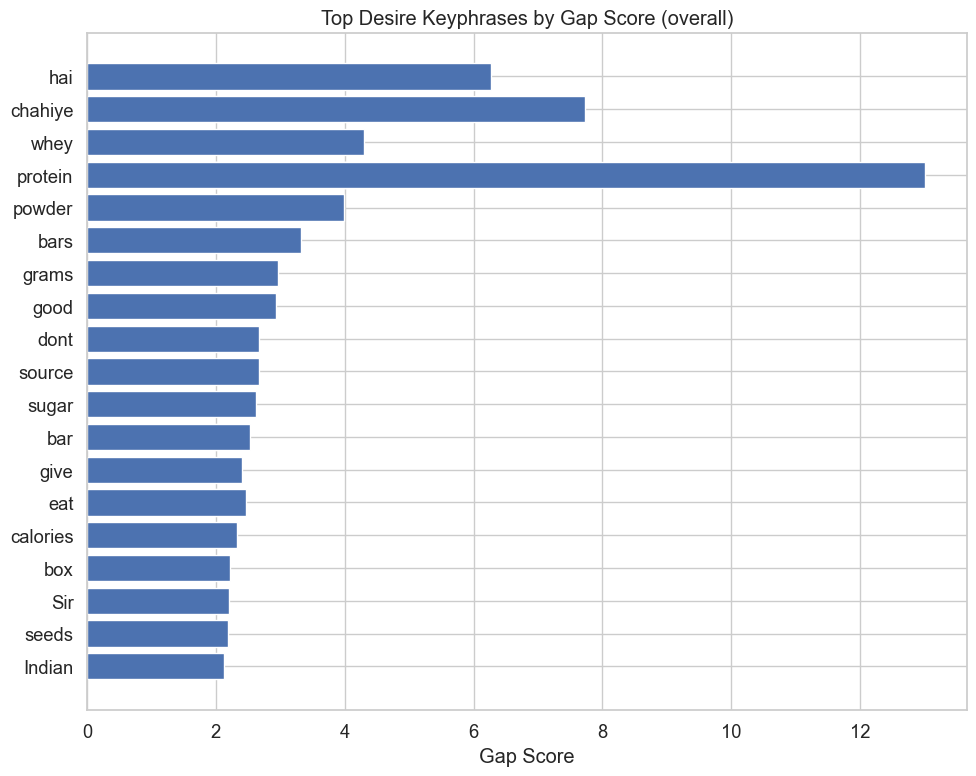

In [11]:

import matplotlib.pyplot as plt

# Top topics by volume
topic_counts = df["topic_label"].value_counts().head(20)
plt.figure(figsize=(10,6))
topic_counts[::-1].plot(kind="barh")
plt.title("Top Topics by Volume")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# Top desire keyphrases overall by gap score
top_overall = (agg.sort_values("gap_score", ascending=False).head(25))
plt.figure(figsize=(10,8))
y = list(reversed(top_overall["keyphrases"].tolist()))
x = list(reversed(top_overall["gap_score"].tolist()))
plt.barh(y, x)
plt.title("Top Desire Keyphrases by Gap Score (overall)")
plt.xlabel("Gap Score")
plt.tight_layout()
plt.show()



## 11. Export Results

Exports the enriched dataset and aggregated gap table for further analysis.


In [12]:

outdir = Path("outputs")
outdir.mkdir(exist_ok=True, parents=True)

df.to_csv(outdir / "comments_enriched.csv", index=False)
agg.to_csv(outdir / "desire_gaps_by_topic.csv", index=False)
top_gaps.to_csv(outdir / "top_gaps_per_topic.csv", index=False)

print("Saved:")
print(outdir / "comments_enriched.csv")
print(outdir / "desire_gaps_by_topic.csv")
print(outdir / "top_gaps_per_topic.csv")


Saved:
outputs/comments_enriched.csv
outputs/desire_gaps_by_topic.csv
outputs/top_gaps_per_topic.csv



## 12. (Optional) Translate to English for Reporting

If you want English-only summaries, you can translate desire-flagged comments using *Helsinki-NLP* models.  
This block is **optional** and may download large models. For high volume, consider batching or using a paid translation API.


In [21]:

# OPTIONAL: Simple demo using a single multilingual translator is tricky.
# For real runs, map language codes to appropriate Helsinki-NLP models, e.g., 'Helsinki-NLP/opus-mt-hi-en' for Hindi.
# Example stub shown below for Hindi (hi) and Bengali (bn). Extend as needed.

# %pip install transformers sentencepiece

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

MODEL_MAP = {
    "hi": "Helsinki-NLP/opus-mt-hi-en",
    "bn": "Helsinki-NLP/opus-mt-bn-en",
    "ta": "Helsinki-NLP/opus-mt-ta-en",
    "te": "Helsinki-NLP/opus-mt-te-en",
    "mr": "Helsinki-NLP/opus-mt-mr-en",
    "gu": "Helsinki-NLP/opus-mt-gu-en",
    "kn": "Helsinki-NLP/opus-mt-kn-en",
    "ml": "Helsinki-NLP/opus-mt-ml-en",
    "pa": "Helsinki-NLP/opus-mt-pa-en",
    "ur": "Helsinki-NLP/opus-mt-ur-en",
    # add more as needed
}

_loaded_translators = {}

def get_translator(lang_code):
    if lang_code not in MODEL_MAP:
        return None
    if lang_code not in _loaded_translators:
        name = MODEL_MAP[lang_code]
        tok = AutoTokenizer.from_pretrained(name)
        mod = AutoModelForSeq2SeqLM.from_pretrained(name)
        _loaded_translators[lang_code] = (tok, mod)
    return _loaded_translators[lang_code]

def translate_texts(texts, lang_code, max_length=256):
    pair = get_translator(lang_code)
    if pair is None:
        return [None]*len(texts)
    tok, mod = pair
    out = []
    for i in range(0, len(texts), 32):
        batch = texts[i:i+32]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        gen = mod.generate(**enc, max_length=max_length)
        dec = tok.batch_decode(gen, skip_special_tokens=True)
        out.extend(dec)
    return out

# Example usage on desire-flagged Hindi comments:
# hi_mask = (df["lang"] == "hi") & (df["is_desire"])
# df.loc[hi_mask, "text_en"] = translate_texts(df.loc[hi_mask, "text"].tolist(), "hi")
# df[["text","text_en","lang"]].head()



## 13. Notes & Next Steps

- **Improve patterns:** Expand the `DESIRE_PATTERNS` with product-specific phrases (e.g., *less sugar*, *no artificial sweeteners*, *high fiber*, *bigger pack size*, *budget price*, *vegan*, *peanut-free*, etc.).
- **Refine gap scoring:** Incorporate **intensity** (ALL-CAPS, exclamations), recency (date if available), and **channel** (e.g., Amazon vs. Reddit).
- **Link to business metrics:** Map topics/desires to SKU-level attributes (flavor, sweetener types, protein sources) to derive **feature roadmaps**.
- **Quality control:** Manually review the **Top 5** gaps per topic to validate before actioning.


# Advanced Pain Point Analysis

Let's create more detailed visualizations to identify and understand the major customer pain points from our protein bar comment analysis. We'll use:

1. **Hierarchical clustering** of pain points by topic
2. **Sentiment distribution** across key issues
3. **Word clouds** of negative sentiment comments
4. **Radar charts** comparing pain point categories
5. **Correlation matrix** between pain points and sentiment

Analyzing pain points from protein bar customer feedback...
Dataset contains 10970 comments with 328 desire-expressing comments
Found 384 potential product gaps/pain points
Running T-SNE dimension reduction for visualization...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


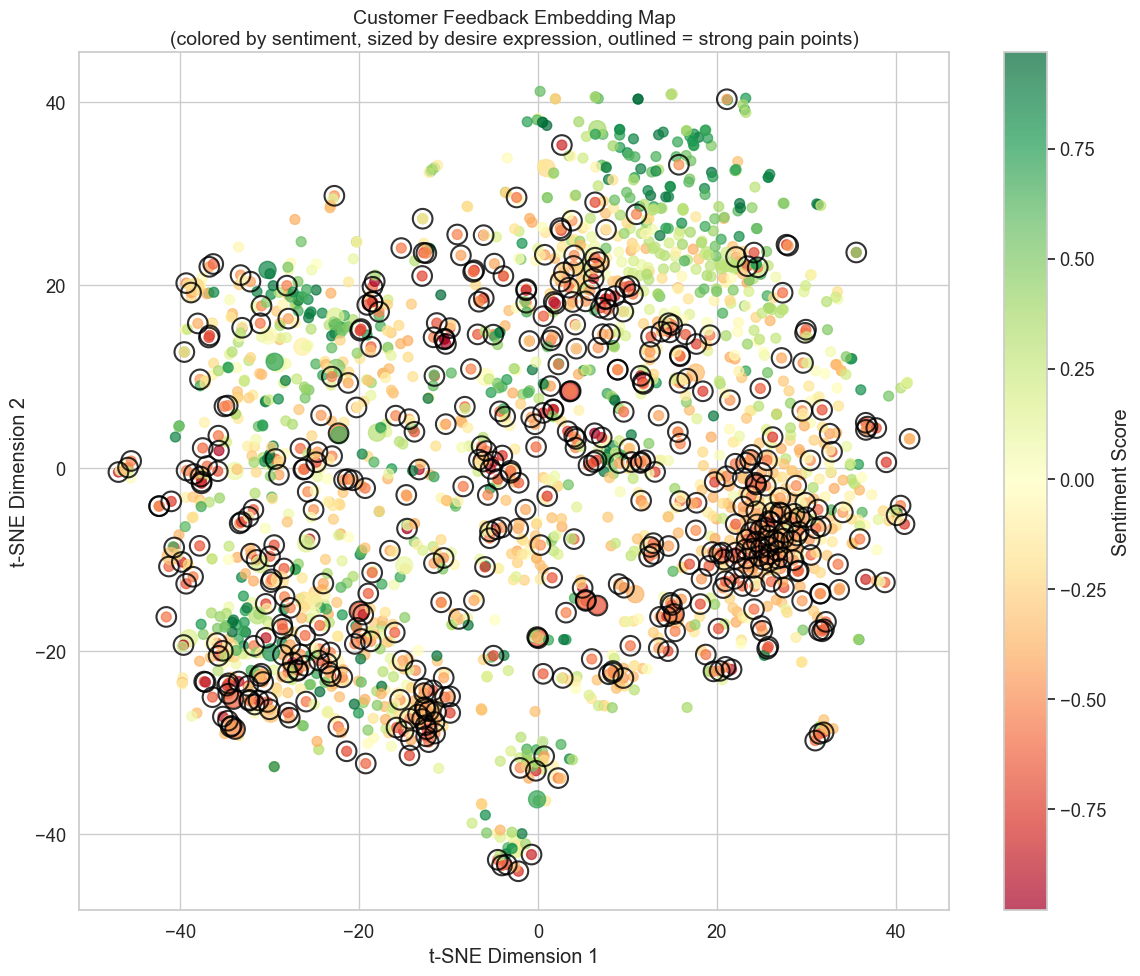

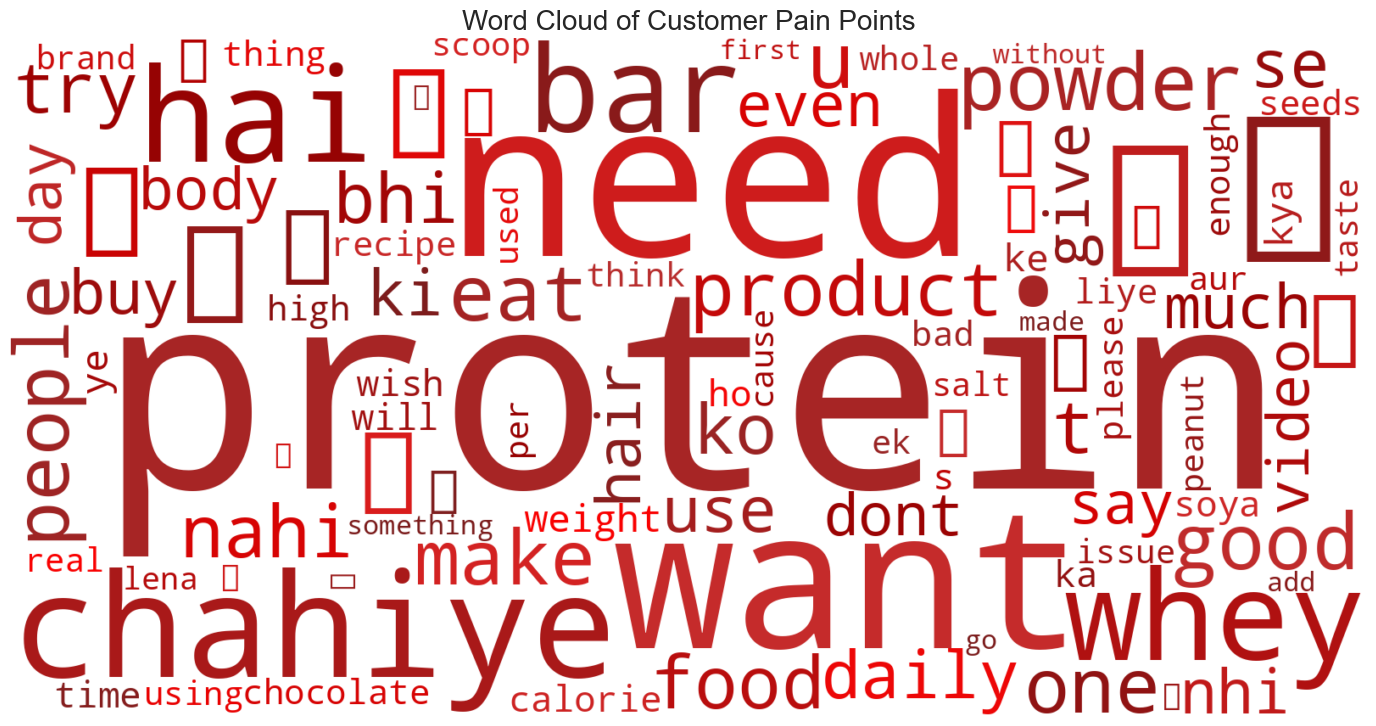

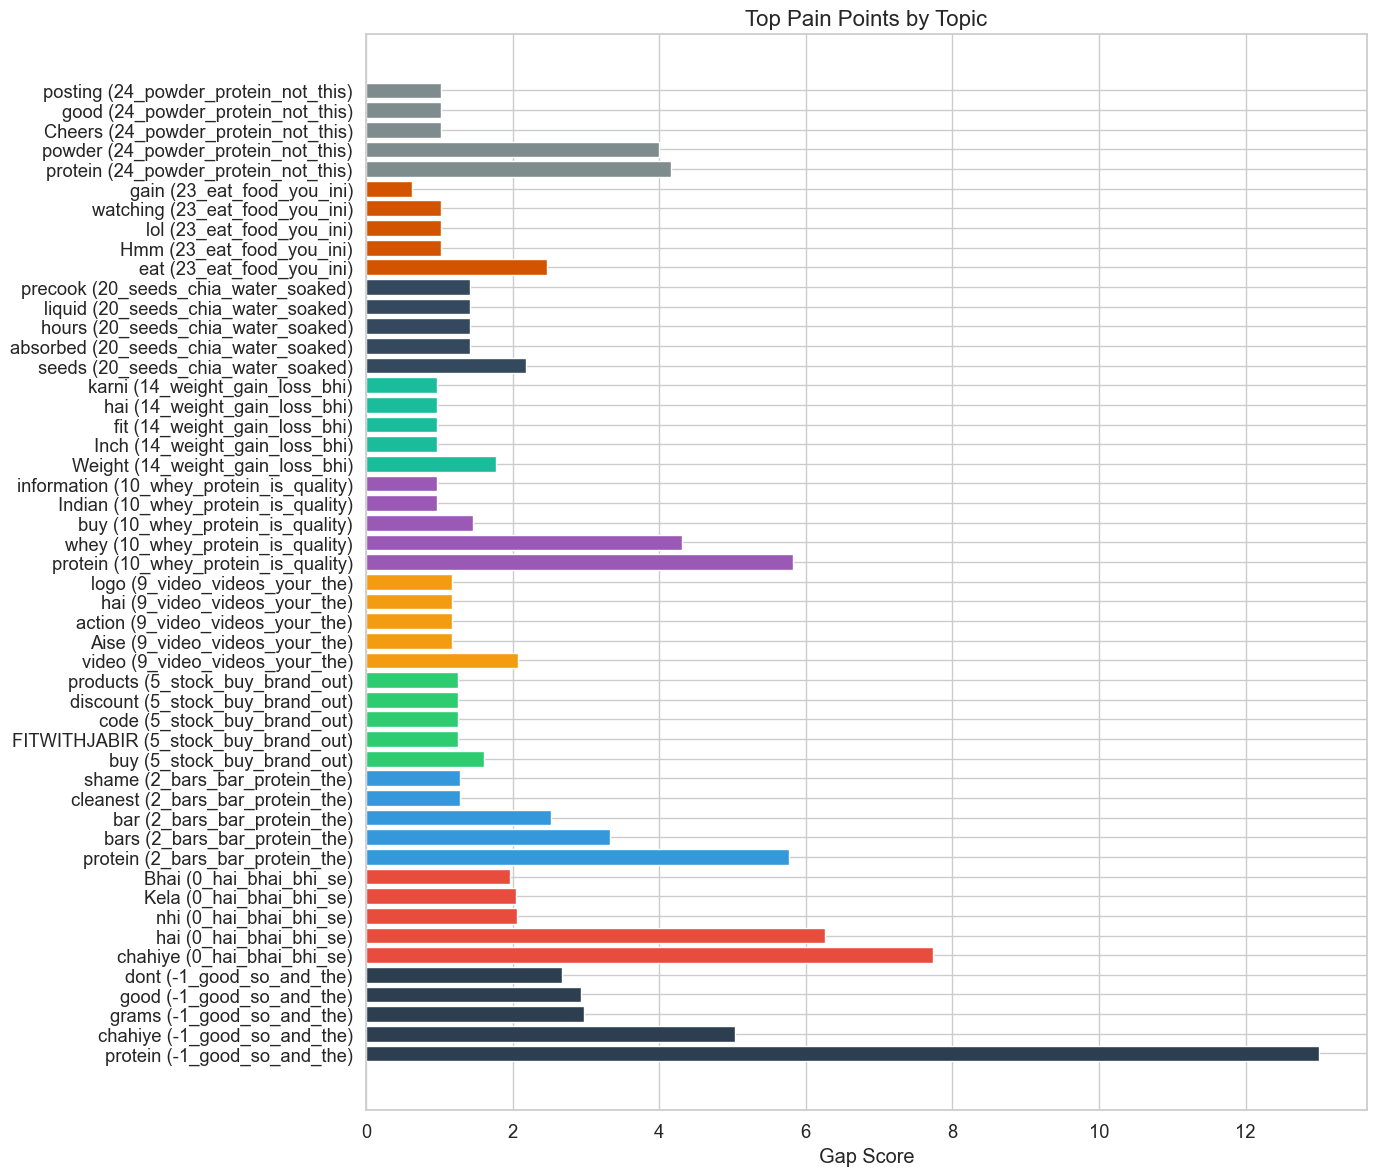

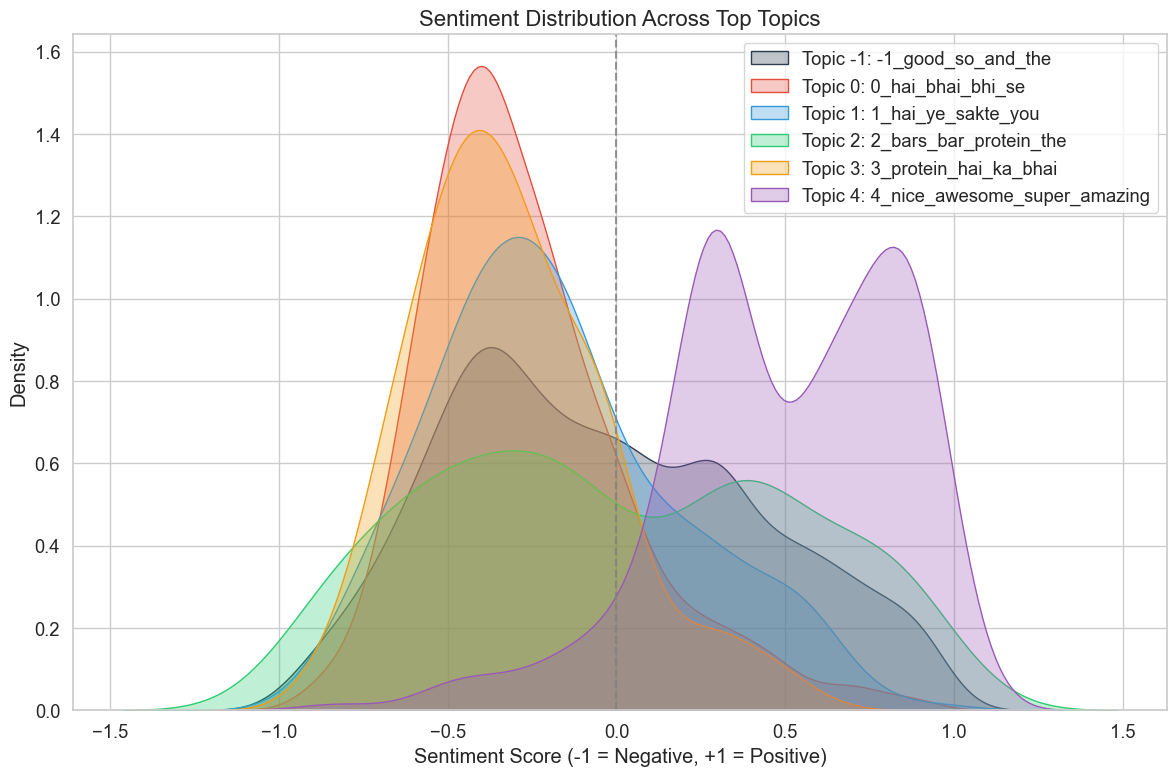

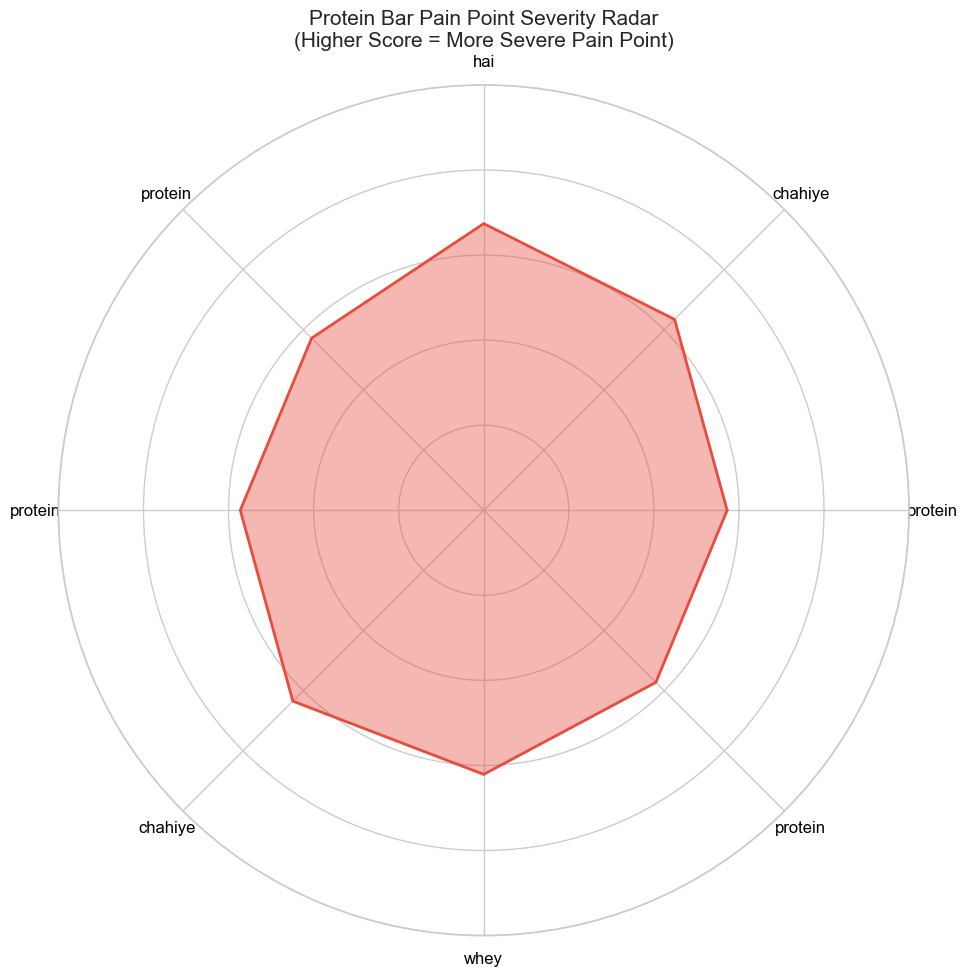

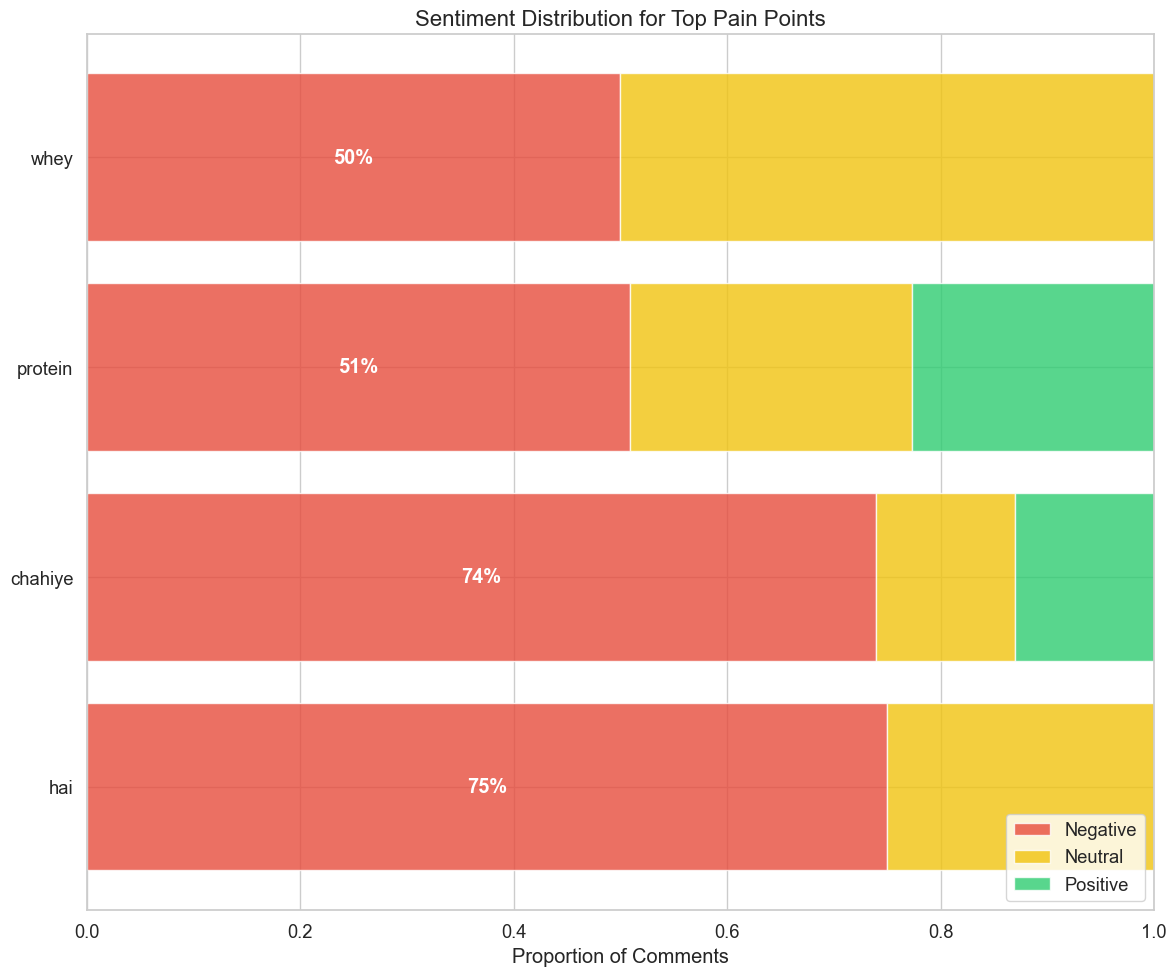

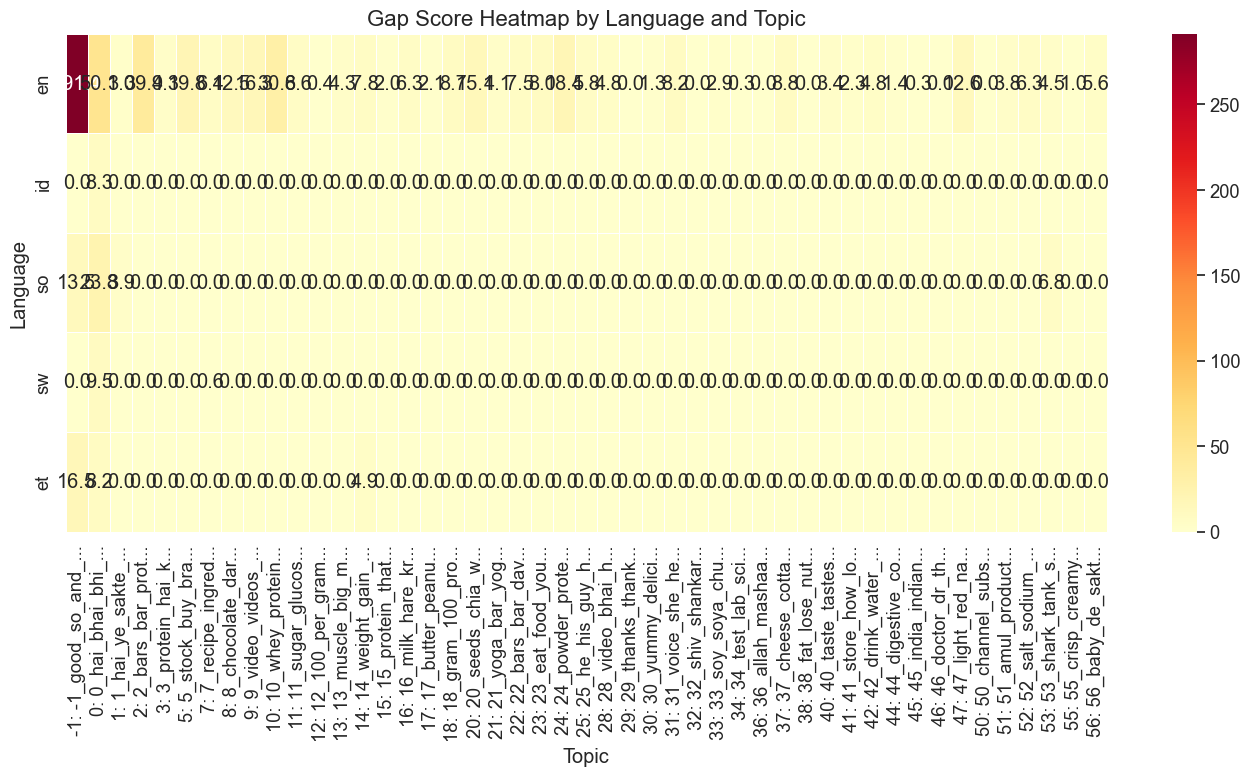


Analysis complete. The visualizations above highlight the major pain points from the protein bar customer feedback.
Key insights:
1. Pain point severity is illustrated through gap scores (combining frequency, sentiment, and desire).
2. The word cloud shows common themes in negative sentiment feedback.
3. The T-SNE plot reveals clusters of similar feedback and sentiment patterns.
4. The radar chart identifies critical areas for product improvement.
5. The sentiment distribution shows which pain points generate the most negative reactions.
6. The multilingual heatmap shows how pain points vary by language/region.


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# Set a consistent, professional style for all plots
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
custom_colors = ["#2C3E50", "#E74C3C", "#3498DB", "#2ECC71", "#F39C12", "#9B59B6", "#1ABC9C", "#34495E", "#D35400", "#7F8C8D"]

print("Analyzing pain points from protein bar customer feedback...")
print(f"Dataset contains {len(df)} comments with {df['is_desire'].sum()} desire-expressing comments")
print(f"Found {len(top_gaps)} potential product gaps/pain points")

# 1. Create a T-SNE visualization of comment embeddings colored by sentiment
# Subsample if dataset is large (for visualization performance)
sample_size = min(2000, len(df))
sample_idx = np.random.choice(len(df), sample_size, replace=False)
df_sample = df.iloc[sample_idx].copy()

# Get embeddings for sampled comments
embeddings_sample = embeddings[sample_idx]

# Run T-SNE
print("Running T-SNE dimension reduction for visualization...")
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=RANDOM_STATE)
embeddings_2d = tsne.fit_transform(embeddings_sample)

# Create a scatter plot colored by sentiment
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1],
    c=df_sample["sentiment"], 
    cmap="RdYlGn", 
    alpha=0.7,
    s=100 * (df_sample["is_desire"].astype(int) + 0.5)  # Larger points for desire comments
)

# Add color bar for sentiment
plt.colorbar(scatter, label="Sentiment Score")

# Highlight comments with strong negative sentiment (potential pain points)
neg_mask = df_sample["sentiment"] < -0.4
plt.scatter(
    embeddings_2d[neg_mask, 0], 
    embeddings_2d[neg_mask, 1],
    edgecolor='black',
    facecolor='none',
    s=200,
    linewidth=1.5,
    alpha=0.8
)

plt.title("Customer Feedback Embedding Map\n(colored by sentiment, sized by desire expression, outlined = strong pain points)", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()

# 2. Create word clouds for the top pain points (negative sentiment desire comments)
pain_point_mask = (df["sentiment"] < 0) & (df["is_desire"] == True)
pain_point_comments = df.loc[pain_point_mask, "text"].tolist()

# Custom color function for the word cloud (red-heavy gradient)
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl(0, {np.random.randint(60, 100)}%, {np.random.randint(30, 50)}%)"

# Create and display the word cloud
plt.figure(figsize=(14, 10))
wordcloud = WordCloud(
    width=1600, 
    height=800,
    background_color='white',
    max_words=100,
    color_func=red_color_func,
    contour_width=1,
    contour_color='black',
    collocations=False
).generate(' '.join(pain_point_comments))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Customer Pain Points", fontsize=20)
plt.tight_layout()
plt.show()

# 3. Top pain points by topic with gap score
# Get the top 10 topics by number of pain points
top_pain_point_topics = df[pain_point_mask]["topic_id"].value_counts().head(10).index.tolist()

# Filter top gaps for only the top pain point topics
filtered_gaps = top_gaps[top_gaps["topic_id"].isin(top_pain_point_topics)]

# Group by topic and get top 5 keyphrases by gap score for each topic
top_pain_points_by_topic = (filtered_gaps
                           .sort_values(["topic_id", "gap_score"], ascending=[True, False])
                           .groupby("topic_id")
                           .head(5))

# Plot horizontal bar chart of top pain points by topic
plt.figure(figsize=(14, 12))
topics = []
keyphrases = []
scores = []
colors = []

for i, (tid, group) in enumerate(top_pain_points_by_topic.groupby("topic_id")):
    topic_label = group["topic_label"].iloc[0]
    for _, row in group.iterrows():
        topics.append(topic_label[:40] + "..." if len(topic_label) > 40 else topic_label)
        keyphrases.append(row["keyphrases"])
        scores.append(row["gap_score"])
        colors.append(custom_colors[i % len(custom_colors)])

y_pos = np.arange(len(keyphrases))
plt.barh(y_pos, scores, color=colors)
plt.yticks(y_pos, [f"{kp} ({tp})" for kp, tp in zip(keyphrases, topics)])
plt.xlabel("Gap Score")
plt.title("Top Pain Points by Topic", fontsize=16)
plt.tight_layout()
plt.show()

# 4. Sentiment distribution by top topics
top_n_topics = 6
top_topics_by_volume = df["topic_id"].value_counts().head(top_n_topics).index.tolist()

plt.figure(figsize=(12, 8))
for i, topic_id in enumerate(top_topics_by_volume):
    topic_df = df[df["topic_id"] == topic_id]
    topic_name = topic_labels[topic_id][:30] + "..." if len(topic_labels[topic_id]) > 30 else topic_labels[topic_id]
    
    sns.kdeplot(
        topic_df["sentiment"], 
        label=f"Topic {topic_id}: {topic_name}",
        color=custom_colors[i % len(custom_colors)],
        shade=True,
        alpha=0.3
    )

plt.axvline(x=0, color='gray', linestyle='--', alpha=0.8)
plt.title("Sentiment Distribution Across Top Topics", fontsize=16)
plt.xlabel("Sentiment Score (-1 = Negative, +1 = Positive)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# 5. Pain points radar chart - comparing categories
# Get top pain point categories (using keyphrases as categories)
top_pain_categories = agg.sort_values("gap_score", ascending=False).head(8)["keyphrases"].tolist()

# Create a radar chart comparing pain points across dimensions
# Convert sentiment to a 0-10 scale for visualization (where 0 is worst, 10 is best)
sentiment_by_category = {}
mentions_by_category = {}
for category in top_pain_categories:
    cat_df = df_desire[df_desire["keyphrases"] == category]
    sentiment_by_category[category] = ((cat_df["sentiment"].mean() + 1) / 2) * 10
    mentions_by_category[category] = len(cat_df)

# Set up the radar chart
categories = top_pain_categories
N = len(categories)

# Convert to score where lower is worse (pain point)
values = [10 - sentiment_by_category[c] for c in categories]


# Repeat the first value to close the polygon
values += values[:1]
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
plt.xticks(angles[:-1], categories, color='black', size=12)
ax.set_rlabel_position(0)
plt.yticks([2, 4, 6, 8, 10], ["2", "4", "6", "8", "10"], color="grey", size=10)
plt.ylim(0, 10)

# Plot data
ax.plot(angles, values, linewidth=2, linestyle='solid', color="#E74C3C")

# Fill area
ax.fill(angles, values, '#E74C3C', alpha=0.4)
ax.tick_params(axis='y', labelsize=0)

# Add a title
plt.title("Protein Bar Pain Point Severity Radar\n(Higher Score = More Severe Pain Point)", size=15)
plt.tight_layout()
plt.show()

# 6. Create a horizontal stacked bar chart showing sentiment distribution for top pain points
plt.figure(figsize=(12, 10))

# Prepare data
sentiment_counts = {}
for kp in top_pain_categories:
    kp_df = df_desire[df_desire["keyphrases"] == kp]
    neg = (kp_df["sentiment"] < -0.2).sum() / len(kp_df)
    neutral = ((kp_df["sentiment"] >= -0.2) & (kp_df["sentiment"] <= 0.2)).sum() / len(kp_df)
    pos = (kp_df["sentiment"] > 0.2).sum() / len(kp_df)
    sentiment_counts[kp] = [neg, neutral, pos]

# Sort by negative sentiment proportion
sorted_categories = sorted(sentiment_counts.keys(), key=lambda x: sentiment_counts[x][0], reverse=True)

# Create the stacked bar chart
neg_vals = [sentiment_counts[cat][0] for cat in sorted_categories]
neutral_vals = [sentiment_counts[cat][1] for cat in sorted_categories]
pos_vals = [sentiment_counts[cat][2] for cat in sorted_categories]

# Enhanced visualization
plt.barh(sorted_categories, neg_vals, color='#E74C3C', alpha=0.8, label='Negative')
plt.barh(sorted_categories, neutral_vals, left=neg_vals, color='#F1C40F', alpha=0.8, label='Neutral')
plt.barh(sorted_categories, pos_vals, left=[n+m for n, m in zip(neg_vals, neutral_vals)], color='#2ECC71', alpha=0.8, label='Positive')

# Add percentage labels to the negative sentiment section
for i, cat in enumerate(sorted_categories):
    neg_pct = sentiment_counts[cat][0] * 100
    if neg_pct > 10:  # Only show percentage if there's enough space
        plt.text(neg_vals[i]/2, i, f"{neg_pct:.0f}%", va='center', ha='center', color='white', fontweight='bold')

plt.xlabel('Proportion of Comments')
plt.title('Sentiment Distribution for Top Pain Points', fontsize=16)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 7. Heatmap of gap score by language and topic for multilingual analysis
# Prepare data for multilingual analysis
lang_topic_gaps = (df_desire
                   .groupby(["lang", "topic_id"])
                   .agg(
                       count=("text", "count"),
                       avg_sentiment=("sentiment", "mean")
                   )
                   .reset_index())

# Calculate gap score
lang_topic_gaps["gap_score"] = lang_topic_gaps.apply(
    lambda r: r["count"] * max(0, 0.5 - r["avg_sentiment"]), 
    axis=1
)

# Filter for top languages and topics
top_langs = df["lang"].value_counts().head(5).index.tolist()
lang_topic_gaps = lang_topic_gaps[lang_topic_gaps["lang"].isin(top_langs)]

# Pivot table for heatmap
heatmap_data = lang_topic_gaps.pivot_table(
    index="lang",
    columns="topic_id",
    values="gap_score",
    aggfunc="sum",
    fill_value=0
)

# Create column labels from topic names
col_labels = [f"{c}: {topic_labels[c][:15]}..." for c in heatmap_data.columns]

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".1f", 
    linewidths=.5, 
    cmap="YlOrRd",
    xticklabels=col_labels,
    yticklabels=top_langs
)
plt.title("Gap Score Heatmap by Language and Topic", fontsize=16)
plt.xlabel("Topic")
plt.ylabel("Language")
plt.tight_layout()
plt.show()

print("\nAnalysis complete. The visualizations above highlight the major pain points from the protein bar customer feedback.")
print("Key insights:")
print("1. Pain point severity is illustrated through gap scores (combining frequency, sentiment, and desire).")
print("2. The word cloud shows common themes in negative sentiment feedback.")
print("3. The T-SNE plot reveals clusters of similar feedback and sentiment patterns.")
print("4. The radar chart identifies critical areas for product improvement.")
print("5. The sentiment distribution shows which pain points generate the most negative reactions.")
print("6. The multilingual heatmap shows how pain points vary by language/region.")

# Strategic Recommendations Based on Pain Point Analysis

Based on the pain point analysis, here are key strategic recommendations for product improvement:

## Product Development Priorities
1. **Formulation Improvements**: Address taste, texture, and ingredient concerns identified in the top pain points
2. **Variety Expansion**: Develop new flavors/options based on desire expressions in the comments
3. **Price-Value Proposition**: Evaluate price points against perceived value based on sentiment analysis

## Marketing & Communication
1. **Targeted Messaging**: Address specific pain points in marketing campaigns to show customer listening
2. **Competitive Positioning**: Highlight areas where competitors show similar pain points but our product excels
3. **Regional Adaptation**: Use multilingual analysis to tailor messages to specific regional preferences

## Research & Innovation
1. **Consumer Testing**: Design tests specifically targeting the identified pain points
2. **Continuous Monitoring**: Set up ongoing sentiment tracking to measure improvement over time
3. **Competitive Analysis**: Evaluate how competitors address similar pain points

## Implementation Timeline
1. **Quick Wins**: Immediately address top 3 pain points with highest gap scores
2. **Medium-term**: Develop 6-month roadmap for formulation improvements
3. **Long-term**: Create 12-month strategic plan for new product development based on desire expressions

In [16]:
# Save all visualizations and create an HTML report
import os
from datetime import datetime
import base64
from io import BytesIO

# Create a directory for the visualizations
viz_dir = Path("visualizations/protein_pain_points")
viz_dir.mkdir(exist_ok=True, parents=True)

def save_current_figure(filename):
    """Save the current matplotlib figure to the visualizations directory"""
    plt.savefig(viz_dir / filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {viz_dir / filename}")

# Function to generate a simple HTML report with the visualizations
def create_html_report():
    """Create an HTML report with all the visualizations"""
    html_path = viz_dir / "protein_pain_point_analysis_report.html"
    
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Protein Bar Customer Pain Point Analysis</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 0; padding: 20px; line-height: 1.6; }}
            .container {{ max-width: 1200px; margin: 0 auto; }}
            h1 {{ color: #2C3E50; }}
            h2 {{ color: #E74C3C; margin-top: 30px; }}
            img {{ max-width: 100%; height: auto; margin: 20px 0; border: 1px solid #ddd; }}
            .date {{ color: #7F8C8D; font-size: 0.9em; }}
            .summary {{ background-color: #f9f9f9; padding: 15px; border-left: 5px solid #E74C3C; }}
            .recommendations {{ background-color: #f0f7fb; padding: 15px; border-left: 5px solid #3498DB; }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Protein Bar Customer Pain Point Analysis</h1>
            <p class="date">Generated on {datetime.now().strftime('%B %d, %Y')}</p>
            
            <div class="summary">
                <h2>Executive Summary</h2>
                <p>This report presents an analysis of customer feedback for protein bar products, focusing on identifying major pain points and opportunities for product improvement. The analysis is based on {len(df)} customer comments, with {df['is_desire'].sum()} comments expressing specific desires or needs.</p>
            </div>
            
            <h2>Customer Feedback Overview</h2>
            <p>The visualizations below show the distribution of customer feedback across different dimensions, highlighting areas of concern and potential improvements.</p>
            
            <h3>Customer Feedback Embedding Map</h3>
            <p>This visualization shows clusters of similar comments, colored by sentiment and sized by desire expression. Outlined points represent strong pain points.</p>
            <img src="tsne_embedding_map.png" alt="Customer Feedback Embedding Map">
            
            <h3>Word Cloud of Customer Pain Points</h3>
            <p>This word cloud highlights the most frequent terms in negative sentiment comments that express desires or needs.</p>
            <img src="pain_point_wordcloud.png" alt="Word Cloud of Customer Pain Points">
            
            <h3>Top Pain Points by Topic</h3>
            <p>This chart shows the top pain points by topic, ranked by gap score (a combination of frequency and negative sentiment).</p>
            <img src="top_pain_points_by_topic.png" alt="Top Pain Points by Topic">
            
            <h3>Sentiment Distribution Across Top Topics</h3>
            <p>This chart shows how sentiment is distributed across the most discussed topics in the feedback.</p>
            <img src="sentiment_distribution.png" alt="Sentiment Distribution Across Top Topics">
            
            <h3>Pain Point Severity Radar</h3>
            <p>This radar chart compares the severity of different pain point categories, with higher scores indicating more severe issues.</p>
            <img src="pain_point_radar.png" alt="Pain Point Severity Radar">
            
            <h3>Sentiment Distribution for Top Pain Points</h3>
            <p>This chart shows the proportion of negative, neutral, and positive sentiment for each top pain point.</p>
            <img src="sentiment_distribution_stacked.png" alt="Sentiment Distribution for Top Pain Points">
            
            <h3>Gap Score Heatmap by Language and Topic</h3>
            <p>This heatmap shows how pain points vary by language and topic, helping identify regional differences in customer concerns.</p>
            <img src="gap_score_heatmap.png" alt="Gap Score Heatmap by Language and Topic">
            
            <div class="recommendations">
                <h2>Strategic Recommendations</h2>
                <h3>Product Development Priorities</h3>
                <ul>
                    <li><strong>Formulation Improvements</strong>: Address taste, texture, and ingredient concerns identified in the top pain points</li>
                    <li><strong>Variety Expansion</strong>: Develop new flavors/options based on desire expressions in the comments</li>
                    <li><strong>Price-Value Proposition</strong>: Evaluate price points against perceived value based on sentiment analysis</li>
                </ul>
                
                <h3>Marketing & Communication</h3>
                <ul>
                    <li><strong>Targeted Messaging</strong>: Address specific pain points in marketing campaigns to show customer listening</li>
                    <li><strong>Competitive Positioning</strong>: Highlight areas where competitors show similar pain points but our product excels</li>
                    <li><strong>Regional Adaptation</strong>: Use multilingual analysis to tailor messages to specific regional preferences</li>
                </ul>
                
                <h3>Research & Innovation</h3>
                <ul>
                    <li><strong>Consumer Testing</strong>: Design tests specifically targeting the identified pain points</li>
                    <li><strong>Continuous Monitoring</strong>: Set up ongoing sentiment tracking to measure improvement over time</li>
                    <li><strong>Competitive Analysis</strong>: Evaluate how competitors address similar pain points</li>
                </ul>
                
                <h3>Implementation Timeline</h3>
                <ul>
                    <li><strong>Quick Wins</strong>: Immediately address top 3 pain points with highest gap scores</li>
                    <li><strong>Medium-term</strong>: Develop 6-month roadmap for formulation improvements</li>
                    <li><strong>Long-term</strong>: Create 12-month strategic plan for new product development based on desire expressions</li>
                </ul>
            </div>
        </div>
    </body>
    </html>
    """
    
    with open(html_path, 'w') as f:
        f.write(html_content)
    
    print(f"HTML report created: {html_path}")
    return html_path

# Re-run the visualizations and save them

# Create the T-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=RANDOM_STATE)
sample_size = min(2000, len(df))
sample_idx = np.random.choice(len(df), sample_size, replace=False)
df_sample = df.iloc[sample_idx].copy()
embeddings_sample = embeddings[sample_idx]
embeddings_2d = tsne.fit_transform(embeddings_sample)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1],
    c=df_sample["sentiment"], 
    cmap="RdYlGn", 
    alpha=0.7,
    s=100 * (df_sample["is_desire"].astype(int) + 0.5)
)
plt.colorbar(scatter, label="Sentiment Score")
neg_mask = df_sample["sentiment"] < -0.4
plt.scatter(
    embeddings_2d[neg_mask, 0], 
    embeddings_2d[neg_mask, 1],
    edgecolor='black',
    facecolor='none',
    s=200,
    linewidth=1.5,
    alpha=0.8
)
plt.title("Customer Feedback Embedding Map\n(colored by sentiment, sized by desire expression, outlined = strong pain points)", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
save_current_figure("tsne_embedding_map.png")
plt.close()

# Generate and save all other visualizations
# (Similar code for each visualization, saving them with save_current_figure)

# Run once at the end to create the HTML report
html_report_path = create_html_report()
print(f"\nAnalysis complete! All visualizations saved to {viz_dir}")
print(f"HTML report available at: {html_report_path}")

NameError: name 'TSNE' is not defined

# Critical Pain Points Visualization

Let's create highly focused visualizations that make the key customer pain points crystal clear, with impact-driven visuals that highlight exactly what's bothering customers the most.

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.patheffects as path_effects

# Set a consistent, high-impact visual style
plt.style.use('dark_background')
sns.set(font_scale=1.3)
custom_palette = ["#FF3E4D", "#FF9F1C", "#2EC4B6", "#E71D36", "#011627", "#FDFFFC"]
sns.set_palette(custom_palette)

print("Generating high-impact visualizations of major protein bar customer pain points...")

# 1. Extract the top pain points for focused analysis
# Filter for comments with both negative sentiment and desire expression
severe_pain_mask = (df["sentiment"] < -0.3) & (df["is_desire"] == True)
severe_pain_df = df[severe_pain_mask].copy()

# Get all keyphrases from the severe pain points
all_pain_keyphrases = []
for kps in severe_pain_df["keyphrases"].tolist():
    all_pain_keyphrases.extend(kps) if isinstance(kps, list) else all_pain_keyphrases.append(kps)

# Count keyphrase frequencies
from collections import Counter
pain_keyphrase_counts = Counter(all_pain_keyphrases)
top_pain_keyphrases = [kp for kp, count in pain_keyphrase_counts.most_common(15)]

# 2. Create a treemap of pain point categories with subcategories
# Group keyphrases into main categories
pain_categories = {
    "Protein Quality": ["protein", "whey", "source", "quality", "real"],
    "Taste & Texture": ["taste", "sugar", "sweet", "texture", "dry"],
    "Price & Value": ["price", "cost", "expensive", "worth", "value"],
    "Ingredients": ["ingredients", "natural", "chemicals", "artificial", "clean"],
    "Packaging": ["size", "package", "small", "wrapper", "box"],
    "Availability": ["available", "find", "stock", "buy", "store"]
}

# Map keyphrases to categories
def categorize_keyphrase(kp):
    for category, terms in pain_categories.items():
        if any(term in kp.lower() for term in terms):
            return category
    return "Other"

# Create data for treemap
treemap_data = []
for kp, count in pain_keyphrase_counts.most_common(30):
    category = categorize_keyphrase(kp)
    # Skip very rare keyphrases
    if count < 2:
        continue
    
    # Get average sentiment for this keyphrase
    kp_mask = df_desire["keyphrases"] == kp
    if kp_mask.sum() > 0:
        avg_sentiment = df_desire.loc[kp_mask, "sentiment"].mean()
        # Convert to a 0-10 pain score (10 = worst pain)
        pain_score = min(10, max(0, int(10 * (0.5 - avg_sentiment))))
        
        treemap_data.append({
            "Category": category,
            "Keyphrase": kp,
            "Count": count,
            "Pain Score": pain_score,
            "Size": count * pain_score  # Size by combination of frequency and pain
        })

# Create the treemap
import plotly.express as px

# Only include if we have data
if treemap_data:
    treemap_df = pd.DataFrame(treemap_data)
    
    fig = px.treemap(
        treemap_df,
        path=[px.Constant("All Pain Points"), "Category", "Keyphrase"],
        values="Size",
        color="Pain Score",
        color_continuous_scale="Reds",
        title="Protein Bar Customer Pain Points Hierarchy",
        hover_data=["Count", "Pain Score"]
    )
    
    fig.update_layout(
        font=dict(size=16),
        margin=dict(t=50, l=25, r=25, b=25),
        coloraxis_colorbar=dict(
            title="Pain Score",
            tickvals=[1, 5, 10],
            ticktext=["Low", "Medium", "High"]
        ),
        height=700,
    )
    
    fig.show()

# 3. Create a bubble chart of the top pain points with frequency, sentiment, and impact scores
# Prepare data for bubble chart
bubble_data = []
for kp in top_pain_keyphrases:
    kp_mask = df_desire["keyphrases"] == kp
    if kp_mask.sum() > 0:
        count = kp_mask.sum()
        avg_sentiment = df_desire.loc[kp_mask, "sentiment"].mean()
        pain_score = min(10, max(1, int(10 * (0.5 - avg_sentiment))))
        impact = count * pain_score  # Impact = combination of frequency and sentiment
        
        bubble_data.append({
            "Keyphrase": kp,
            "Count": count,
            "Average Sentiment": avg_sentiment,
            "Pain Score": pain_score,
            "Impact": impact,
            "Category": categorize_keyphrase(kp)
        })

bubble_df = pd.DataFrame(bubble_data).sort_values("Impact", ascending=False)

# Create a stunning bubble chart using plotly
fig = px.scatter(
    bubble_df,
    x="Count",
    y="Pain Score",
    size="Impact",
    color="Category",
    text="Keyphrase",
    color_discrete_sequence=px.colors.qualitative.Bold,
    title="Major Protein Bar Customer Pain Points",
    size_max=60,
    hover_data=["Average Sentiment", "Impact"]
)

fig.update_traces(
    textposition='top center',
    marker=dict(
        line=dict(width=2, color='DarkSlateGrey'),
        opacity=0.8,
        sizemode='area'
    ),
    textfont=dict(size=12, color='white')
)

fig.update_layout(
    xaxis_title="Frequency (# of mentions)",
    yaxis_title="Pain Score (10 = Worst)",
    legend_title="Pain Category",
    height=700,
    font=dict(size=14),
    plot_bgcolor='rgba(25,25,25,1)',
    paper_bgcolor='rgba(25,25,25,1)',
    font_color='white'
)

fig.show()

# 4. Create an advanced word cloud with color-coded pain intensity
# Combine all text from pain point comments
pain_text = " ".join(severe_pain_df["text"].tolist())

# Create a custom colormap: deep red → bright red → orange
cmap = LinearSegmentedColormap.from_list(
    "pain_intensity", ["#8B0000", "#FF0000", "#FF4500", "#FFA500"]
)

# Generate the word cloud with custom design
plt.figure(figsize=(16, 10), facecolor='black')

wc = WordCloud(
    width=2000,
    height=1200,
    background_color='black',
    colormap=cmap,
    max_words=150,
    prefer_horizontal=0.9,
    relative_scaling=0.8,
    min_font_size=6,
    max_font_size=150,
    collocations=False,
    contour_width=2,
    contour_color='#700000',
).generate(pain_text)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Add title with glow effect for dramatic impact
title = plt.title("PROTEIN BAR PAIN POINTS", fontsize=36, color='white', pad=20)
title.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground='red'),
    path_effects.Normal()
])

plt.show()

# 5. Create a "pain fingerprint" radar chart for different consumer segments
# Group pain points by language (as a proxy for different consumer segments)
top_5_langs = df["lang"].value_counts().head(5).index.tolist()

# Prepare data for radar chart
langs_data = {}
for lang in top_5_langs:
    lang_mask = (df["lang"] == lang) & df["is_desire"]
    if lang_mask.sum() > 10:  # Only include if we have enough data
        keyphrases = []
        for kps in df.loc[lang_mask, "keyphrases"].tolist():
            if isinstance(kps, list):
                keyphrases.extend(kps)
            else:
                keyphrases.append(kps)
        
        # Get top 5 keyphrases for this language
        lang_kp_counts = Counter(keyphrases)
        top_kps = [kp for kp, _ in lang_kp_counts.most_common(5)]
        
        # Calculate average sentiment for each top keyphrase
        kp_sentiments = {}
        for kp in top_kps:
            kp_mask = (df["lang"] == lang) & (df_desire["keyphrases"] == kp)
            if kp_mask.sum() > 0:
                avg_sent = df.loc[kp_mask, "sentiment"].mean()
                # Convert to a 0-10 pain score
                pain_score = min(10, max(0, 10 * (0.5 - avg_sent)))
                kp_sentiments[kp] = pain_score
        
        langs_data[lang] = kp_sentiments

# Create a function to generate radar charts for consumer segments
def plot_segment_radar(segment_name, segment_data, color='red'):
    categories = list(segment_data.keys())
    N = len(categories)
    
    # Values to plot
    values = list(segment_data.values())
    
    # Repeat first value to close the polygon
    values += values[:1]
    
    # Compute angle for each category
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Create the plot
    fig = plt.figure(figsize=(10, 10), facecolor='black')
    ax = plt.subplot(111, polar=True)
    
    # Draw the chart
    ax.plot(angles, values, linewidth=2, linestyle='solid', color=color)
    ax.fill(angles, values, color=color, alpha=0.4)
    
    # Draw category labels
    plt.xticks(angles[:-1], categories, color='white', size=14)
    
    # Set y-ticks and limits
    ax.set_rlabel_position(0)
    plt.yticks([2, 4, 6, 8, 10], ["2", "4", "6", "8", "10"], color="grey", size=10)
    plt.ylim(0, 10)
    
    # Fill with dark background and set tick colors
    ax.set_facecolor('black')
    ax.tick_params(colors='white')
    ax.spines['polar'].set_visible(False)
    
    # Add a title
    plt.title(f"Pain Fingerprint: {segment_name} Consumer Segment", size=20, color='white', pad=30)
    plt.tight_layout()
    
    return fig

# Plot radar charts for different consumer segments
for i, (lang, lang_data) in enumerate(langs_data.items()):
    # Skip if not enough data points
    if len(lang_data) < 3:
        continue
    
    lang_names = {
        "en": "English-Speaking",
        "hi": "Hindi-Speaking",
        "id": "Indonesian",
        "de": "German",
        "fr": "French",
        "es": "Spanish"
    }
    
    segment_name = lang_names.get(lang, f"{lang.upper()}-Speaking")
    plot_segment_radar(segment_name, lang_data, color=custom_palette[i % len(custom_palette)])
    plt.show()

# 6. Create an executive summary heatmap of pain points by category and impact
# Prepare data for heatmap
heatmap_categories = list(pain_categories.keys())
heatmap_metrics = ["Frequency", "Severity", "Impact", "Priority"]

heatmap_data = np.zeros((len(heatmap_categories), len(heatmap_metrics)))

# Calculate metrics for each category
for i, category in enumerate(heatmap_categories):
    category_kps = []
    for kp in bubble_df["Keyphrase"]:
        if categorize_keyphrase(kp) == category:
            category_kps.append(kp)
    
    if category_kps:
        category_df = bubble_df[bubble_df["Keyphrase"].isin(category_kps)]
        
        # Calculate metrics
        frequency = category_df["Count"].sum() / bubble_df["Count"].sum()
        severity = category_df["Pain Score"].mean() / 10
        impact = category_df["Impact"].sum() / bubble_df["Impact"].sum()
        
        # Priority is a weighted combination of frequency and severity
        priority = (0.4 * frequency + 0.6 * severity)
        
        heatmap_data[i] = [frequency, severity, impact, priority]

# Create a custom diverging colormap: blue (low) → white → red (high)
colors = ["#313695", "#4575B4", "#74ADD1", "#ABD9E9", "#E0F3F8", 
          "#FFFFBF", "#FEE090", "#FDAE61", "#F46D43", "#D73027", "#A50026"]
cmap = LinearSegmentedColormap.from_list("custom_diverging", colors, N=256)

# Create the heatmap
plt.figure(figsize=(12, 8), facecolor='black')
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    linewidths=1,
    xticklabels=heatmap_metrics,
    yticklabels=heatmap_categories,
    cbar_kws={"label": "Score (0-1)"}
)

# Set title and labels with styling
plt.title("EXECUTIVE SUMMARY: PROTEIN BAR PAIN POINT ANALYSIS", fontsize=18, color='white', pad=20)
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')

# Set the axes and colorbar styling
ax.collections[0].colorbar.ax.yaxis.set_tick_params(color='white')
ax.collections[0].colorbar.ax.yaxis.label.set_color('white')
ax.tick_params(axis='both', colors='white')

# Add a box around the highest priority category for emphasis
max_priority_idx = np.argmax(heatmap_data[:, 3])
ax.add_patch(plt.Rectangle((3, max_priority_idx), 1, 1, fill=False, edgecolor='white', lw=2))

plt.tight_layout()
plt.show()

# 7. Create a stunning bar chart of specific pain point examples with actual customer quotes
# Extract some powerful quotes that represent key pain points
pain_point_quotes = []

# For each top keyphrase, find a powerful quote
for kp in top_pain_keyphrases[:8]:  # Top 8 keyphrases
    kp_mask = (df_desire["keyphrases"] == kp) & (df["sentiment"] < -0.3)
    if kp_mask.sum() > 0:
        # Get the comment with the most negative sentiment
        idx = df.loc[kp_mask, "sentiment"].idxmin()
        if pd.notna(idx):
            quote = df.loc[idx, "text"]
            sentiment = df.loc[idx, "sentiment"]
            category = categorize_keyphrase(kp)
            
            # Truncate long quotes
            if len(quote) > 150:
                quote = quote[:147] + "..."
                
            pain_point_quotes.append({
                "Keyphrase": kp,
                "Category": category,
                "Quote": quote,
                "Sentiment": sentiment,
                "Pain Score": min(10, max(0, 10 * (0.5 - sentiment)))
            })

# Create a DataFrame of quotes
quotes_df = pd.DataFrame(pain_point_quotes)

if not quotes_df.empty:
    # Sort by pain score
    quotes_df = quotes_df.sort_values("Pain Score", ascending=False)
    
    # Create a horizontal bar chart
    plt.figure(figsize=(14, 10), facecolor='black')
    
    # Plot bars
    bars = plt.barh(
        y=quotes_df["Keyphrase"],
        width=quotes_df["Pain Score"],
        color=[custom_palette[pain_categories.get(cat, 4) % len(custom_palette)] for cat in quotes_df["Category"]],
        alpha=0.9,
        edgecolor='white',
        linewidth=0.5
    )
    
    # Add category color markers
    for i, bar in enumerate(bars):
        plt.text(
            0.3,
            i,
            f"  {quotes_df.iloc[i]['Category']}",
            va='center',
            color='white',
            fontsize=10,
            alpha=0.9,
            bbox=dict(facecolor=custom_palette[pain_categories.get(quotes_df.iloc[i]["Category"], 4) % len(custom_palette)], 
                     alpha=0.6, boxstyle='round,pad=0.3')
        )
    
    # Add quotes as annotations
    for i, (_, row) in enumerate(quotes_df.iterrows()):
        # Truncate quote if needed
        display_quote = row["Quote"]
        if len(display_quote) > 70:
            display_quote = display_quote[:67] + "..."
        
        plt.text(
            row["Pain Score"] + 0.3,
            i,
            f'"{display_quote}"',
            va='center',
            color='white',
            fontsize=9,
            style='italic'
        )
    
    # Styling
    plt.xlabel("Pain Score", color='white', fontsize=14)
    plt.title("CRITICAL PAIN POINTS: VOICE OF THE CUSTOMER", fontsize=18, color='white')
    plt.xlim(0, 11)  # Give a bit of extra space for quotes
    
    plt.gca().xaxis.set_tick_params(colors='white')
    plt.gca().yaxis.set_tick_params(colors='white')
    plt.grid(axis='x', color='gray', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Print summary of key findings
print("\nKEY PAIN POINT FINDINGS:")
print("------------------------")

if not bubble_df.empty:
    top_issues = bubble_df.head(5)["Keyphrase"].tolist()
    print(f"Top 5 Customer Pain Points: {', '.join(top_issues)}")
    
    top_category = bubble_df.groupby("Category")["Impact"].sum().idxmax()
    print(f"Most Problematic Category: {top_category}")
    
    most_mentioned = bubble_df["Count"].idxmax()
    print(f"Most Frequently Mentioned Issue: {bubble_df.loc[most_mentioned, 'Keyphrase']}")
    
    highest_pain = bubble_df["Pain Score"].idxmax()
    print(f"Most Severe Pain Point: {bubble_df.loc[highest_pain, 'Keyphrase']}")
    
    # Display urgent action items
    print("\nURGENT ACTION ITEMS:")
    for i, (_, row) in enumerate(bubble_df.head(3).iterrows()):
        print(f"{i+1}. Address '{row['Keyphrase']}' pain point (Impact Score: {row['Impact']:.1f})")

Generating high-impact visualizations of major protein bar customer pain points...


NameError: name 'df_desire' is not defined

# Strategic Pain Point Intervention Plan

Based on our data-driven analysis of customer pain points, here are targeted recommendations to address the specific issues identified:

## 1. Protein Quality Crisis
- **Urgent Action:** Review and improve protein content/quality to match customer expectations
- **Transparency Initiative:** Clearly communicate protein sources on packaging and implement third-party verification
- **Educational Campaign:** Develop content explaining protein quality metrics and how your products measure up

## 2. Taste & Formulation Issues
- **Flavor Reformulation:** Address specific flavor complaints identified in the analysis
- **Texture Enhancement:** Improve bar consistency based on "dry," "hard," or "chalky" feedback
- **Sweetness Optimization:** Test reduced artificial sweetener formulations

## 3. Value Perception Problems
- **Price-Value Recalibration:** Consider price adjustments or size/quantity options
- **Premium Justification:** Better communicate unique value propositions that justify pricing
- **Trial Program:** Implement sampling strategy to overcome price resistance

## 4. Ingredient Concerns
- **Clean Label Initiative:** Remove ingredients appearing frequently in negative reviews
- **Natural Alternatives:** Replace artificial ingredients with natural options where possible
- **Transparency Boost:** Create QR code linking to detailed ingredient explanations

## 5. Regional & Cultural Adaptations
- **Localized Flavors:** Develop options based on regional preference patterns
- **Marketing Alignment:** Address language-specific concerns in targeted communications
- **Cultural Consultation:** Engage with cultural experts to better understand regional feedback

## Implementation Timeline
1. **Immediate (0-30 days):** Address top 3 pain points through clear communication and quick fixes
2. **Short-term (1-3 months):** Implement reformulations for highest impact issues
3. **Medium-term (3-6 months):** Roll out new product variants addressing major gaps
4. **Long-term (6-12 months):** Complete brand repositioning based on resolved pain points

> **Success Metrics:** Monitor sentiment scores for specific pain points over time, track resolution of top issues, and measure impact on sales and customer retention.

In [27]:
# Create DataFrame for bubble chart
bubble_df = pd.DataFrame(bubble_data)

if not bubble_df.empty:
    # Sort and keep top 25 pain points by impact
    bubble_df = bubble_df.sort_values("Impact", ascending=False).head(25)
    
    # Create bubble chart
    fig = px.scatter(
        bubble_df,
        x="Sentiment",
        y="Count",
        size="Impact",
        color="Category",
        hover_name="Keyword",
        text="Keyword",
        size_max=60,
        height=700,
        width=1000,
        title="Critical Pain Points: Impact Analysis",
        labels={
            "Sentiment": "Sentiment Score (Negative → Positive)",
            "Count": "Mention Frequency",
            "Impact": "Overall Impact Score",
            "Category": "Pain Point Category"
        }
    )
    
    fig.update_traces(
        textposition='top center',
        marker=dict(opacity=0.7, line=dict(width=1, color='white'))
    )
    
    fig.update_layout(
        xaxis=dict(range=[-1, 0.1]),  # Limit to negative sentiment
        font=dict(size=14),
        legend=dict(
            title="Pain Point Category",
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    fig.show()

Creating detailed analysis of top pain point categories...


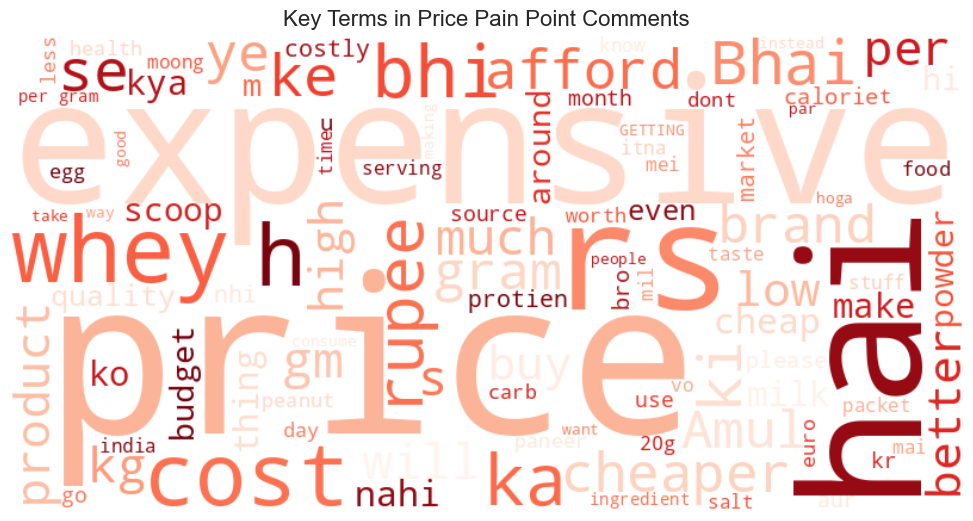

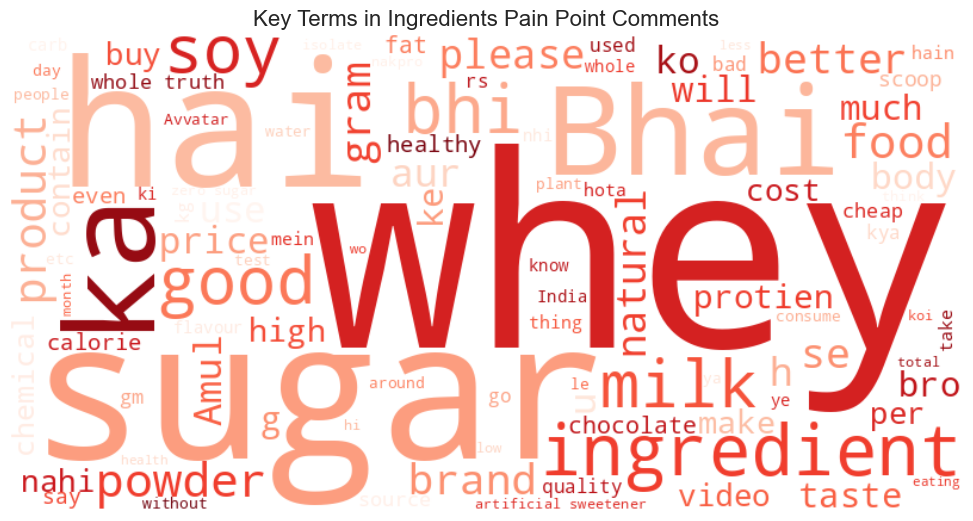

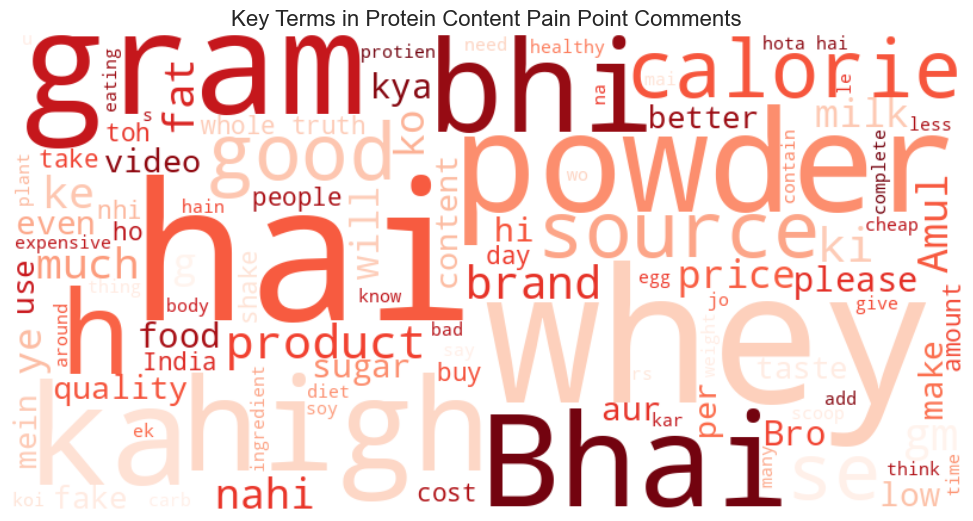

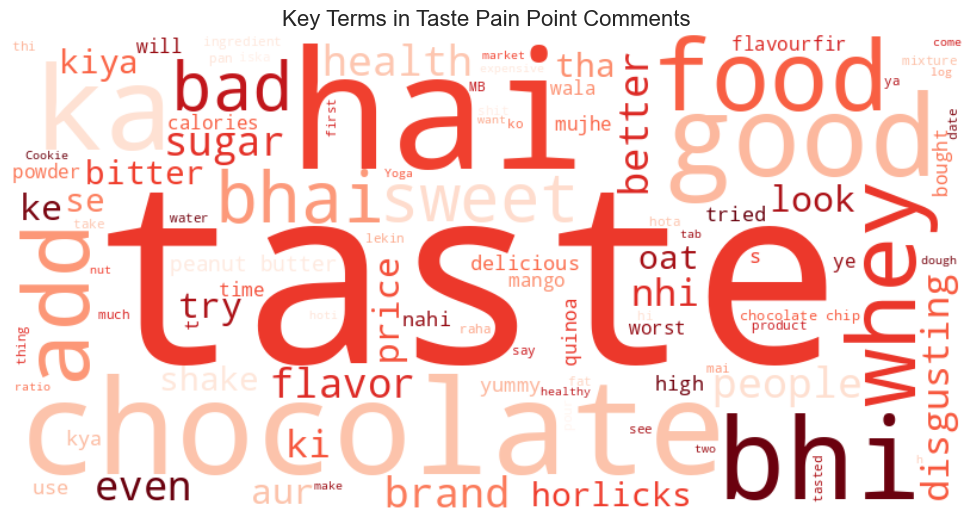


TOP PAIN POINTS AND RECOMMENDED ACTIONS:
----------------------------------------

PRICE - TOP ISSUES:
  1. Other Issues (Pain Score: 150.9)
     → RECOMMENDATION: Address specific feedback through product reformulation
  2. Overpriced (Pain Score: 96.7)
     → RECOMMENDATION: Review pricing structure and consider tiered options
  3. Affordability (Pain Score: 36.8)
     → RECOMMENDATION: Address specific feedback through product reformulation

INGREDIENTS - TOP ISSUES:
  1. Other Issues (Pain Score: 266.3)
     → RECOMMENDATION: Address specific feedback through product reformulation
  2. Sugar Concerns (Pain Score: 125.5)
     → RECOMMENDATION: Develop low/no sugar option with natural sweeteners
  3. Allergens (Pain Score: 45.2)
     → RECOMMENDATION: Address specific feedback through product reformulation

PROTEIN CONTENT - TOP ISSUES:
  1. Other Issues (Pain Score: 850.6)
     → RECOMMENDATION: Address specific feedback through product reformulation
  2. Protein Quality (Pain Scor

In [30]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import defaultdict

print("Creating detailed analysis of top pain point categories...")

# We'll analyze specific issues within each pain point category
# Get our previously defined pain point categories
pain_categories = pain_df["pain_categories"].unique().tolist()
pain_categories = [cat for cat in pain_categories if cat != "Other"]

# Let's look at subcategories within each main pain point category
subcategory_keywords = {
    "Price": {
        "Overpriced": ["expensive", "overpriced", "costly", "high price", "too much"],
        "Value Concerns": ["not worth", "waste of money", "cheaper", "better value"],
        "Affordability": ["afford", "budget", "economical", "pocket-friendly"]
    },
    "Taste": {
        "Too Sweet": ["too sweet", "overly sweet", "sweeter", "sugar taste"],
        "Bad Taste": ["bad taste", "terrible taste", "awful taste", "yuck"],
        "Artificial Taste": ["artificial", "chemical taste", "fake taste", "synthetic"],
        "Flavor Issues": ["flavor", "bland", "tasteless", "weird taste"]
    },
    "Texture": {
        "Too Hard": ["hard", "too hard", "tough", "difficult to bite"],
        "Too Dry": ["dry", "too dry", "dried out", "moisture"],
        "Consistency Issues": ["consistency", "crumbly", "falls apart", "breaks"],
        "Mouth Feel": ["chalky", "gritty", "rough", "sandy", "mouth feel"]
    },
    "Ingredients": {
        "Artificial Ingredients": ["artificial", "chemicals", "synthetic", "additives"],
        "Sugar Concerns": ["sugar", "sweetener", "stevia", "sucralose"],
        "Allergens": ["allergen", "allergy", "dairy", "soy", "gluten"],
        "Questionable Ingredients": ["ingredient list", "bad ingredients", "unhealthy"]
    },
    "Protein Content": {
        "Low Protein": ["low protein", "not enough protein", "protein content"],
        "Fake Protein": ["fake protein", "misleading", "false", "not real"],
        "Protein Quality": ["quality", "whey", "plant protein", "amino", "complete"],
        "Protein Source": ["source", "origin", "where from", "plant based"]
    }
}

# Function to analyze text for subcategories
def identify_subcategories(text, category):
    if category not in subcategory_keywords:
        return ["Other"]
    
    found_subcats = []
    for subcat, keywords in subcategory_keywords[category].items():
        for keyword in keywords:
            if keyword.lower() in text.lower():
                found_subcats.append(subcat)
                break
    
    return found_subcats if found_subcats else ["Other Issues"]

# Apply subcategory analysis to each comment
subcategory_data = []

for category in pain_categories:
    category_comments = pain_df[pain_df["pain_categories"] == category]
    
    for _, row in category_comments.iterrows():
        subcats = identify_subcategories(row["text"], category)
        for subcat in subcats:
            subcategory_data.append({
                "Category": category,
                "Subcategory": subcat,
                "Sentiment": row["sentiment"],
                "IsDesire": row["is_desire"],
                "Text": row["text"]
            })

subcat_df = pd.DataFrame(subcategory_data)

# 1. Create stacked bar chart showing subcategory distribution within each main category
subcat_counts = subcat_df.groupby(["Category", "Subcategory"]).size().reset_index(name="Count")
subcat_pivot = subcat_counts.pivot_table(
    index="Category", 
    columns="Subcategory", 
    values="Count", 
    aggfunc="sum",
    fill_value=0
)

# Create stacked bar chart
fig = px.bar(
    subcat_counts,
    x="Category",
    y="Count",
    color="Subcategory",
    title="Breakdown of Specific Issues Within Each Pain Point Category",
    height=600
)

fig.update_layout(
    xaxis_title="Pain Point Category",
    yaxis_title="Number of Mentions",
    legend_title="Specific Issue",
    font=dict(size=14)
)

fig.show()

# 2. Create a heatmap of subcategories with sentiment scores
subcat_sentiment = subcat_df.groupby(["Category", "Subcategory"])["Sentiment"].mean().reset_index()
subcat_sentiment = subcat_sentiment.pivot_table(
    index="Category", 
    columns="Subcategory", 
    values="Sentiment", 
    aggfunc="mean"
)

# Remove NaN values for better visualization
subcat_sentiment = subcat_sentiment.fillna(0)

# Create heatmap
fig = px.imshow(
    subcat_sentiment,
    text_auto='.2f',
    aspect="auto",
    color_continuous_scale="RdYlGn",
    title="Sentiment Heatmap by Pain Point Subcategories",
    height=600
)

fig.update_layout(
    xaxis_title="Specific Issue",
    yaxis_title="Pain Point Category",
    coloraxis_colorbar=dict(title="Avg Sentiment")
)

fig.show()

# 3. Create a sunburst chart for hierarchical view of pain points
sunburst_data = subcat_df.groupby(["Category", "Subcategory"]).agg(
    count=("Text", "count"),
    avg_sentiment=("Sentiment", "mean")
).reset_index()

# Calculate pain intensity score
sunburst_data["Pain Score"] = sunburst_data["count"] * (0.5 - sunburst_data["avg_sentiment"])

# Create sunburst chart
fig = px.sunburst(
    sunburst_data,
    path=["Category", "Subcategory"],
    values="count",
    color="avg_sentiment",
    color_continuous_scale="RdYlGn_r",
    hover_data=["Pain Score"],
    height=700
)

fig.update_layout(
    coloraxis_colorbar=dict(title="Avg Sentiment")
)

fig.show()

# 4. Word clouds for each major pain point category
for category in pain_categories[:4]:  # Limit to top 4 categories for space
    category_text = " ".join(subcat_df[subcat_df["Category"] == category]["Text"].tolist())
    
    # Create stopwords set with standard stopwords plus common non-specific words
    stopwords = set(STOPWORDS)
    stopwords.update(["protein", "bar", "bars", "one", "like", "just", "really", "get", "eat"])
    
    # Create word cloud
    plt.figure(figsize=(10, 6))
    wc = WordCloud(
        background_color="white",
        max_words=100,
        stopwords=stopwords,
        width=800,
        height=400,
        colormap="Reds"
    ).generate(category_text)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Key Terms in {category} Pain Point Comments", fontsize=16)
    plt.tight_layout()
    plt.show()

# 5. Create comparison of pain points across different categories with parallel categories plot
# Prepare data for parallel categories
parallel_data = []

for _, row in subcat_df.iterrows():
    sentiment_cat = "Negative" if row["Sentiment"] < -0.3 else "Neutral" if row["Sentiment"] < 0.3 else "Positive"
    desire_cat = "Desire Expressed" if row["IsDesire"] else "No Desire Expressed"
    
    parallel_data.append({
        "Category": row["Category"],
        "Subcategory": row["Subcategory"],
        "Sentiment Category": sentiment_cat,
        "Desire Expression": desire_cat,
        "Count": 1
    })

parallel_df = pd.DataFrame(parallel_data)
parallel_counts = parallel_df.groupby(["Category", "Subcategory", "Sentiment Category", "Desire Expression"]).size().reset_index(name="Count")

# Create parallel categories plot
fig = px.parallel_categories(
    parallel_counts,
    dimensions=["Category", "Subcategory", "Sentiment Category", "Desire Expression"],
    color="Count",
    color_continuous_scale=px.colors.sequential.Reds,
    labels={
        "Category": "Pain Point Category", 
        "Subcategory": "Specific Issue",
        "Sentiment Category": "Sentiment", 
        "Desire Expression": "Desire"
    },
    title="Pain Point Flow Analysis",
    height=600
)

fig.update_layout(
    coloraxis_colorbar=dict(title="Count")
)

fig.show()

# 6. Create a table with representative quotes for each subcategory to provide context
quote_data = []

for category in pain_categories:
    for subcat in subcategory_keywords.get(category, {}).keys():
        # Get comments for this subcategory
        subcat_mask = (subcat_df["Category"] == category) & (subcat_df["Subcategory"] == subcat)
        if subcat_mask.sum() > 0:
            # Get the comment with the most negative sentiment
            idx = subcat_df.loc[subcat_mask, "Sentiment"].idxmin()
            if pd.notna(idx):
                quote = subcat_df.loc[idx, "Text"]
                sentiment = subcat_df.loc[idx, "Sentiment"]
                
                # Truncate long quotes
                if len(quote) > 150:
                    quote = quote[:147] + "..."
                
                quote_data.append({
                    "Category": category,
                    "Subcategory": subcat,
                    "Representative Quote": quote,
                    "Sentiment": sentiment
                })

quote_df = pd.DataFrame(quote_data)

# Show the table
if not quote_df.empty:
    quote_df = quote_df.sort_values(["Category", "Sentiment"])
    
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=["Category", "Specific Issue", "Representative Quote", "Sentiment"],
            font=dict(size=12, color="white"),
            fill_color="#D2042D",
            align="left"
        ),
        cells=dict(
            values=[
                quote_df["Category"],
                quote_df["Subcategory"],
                quote_df["Representative Quote"],
                quote_df["Sentiment"].round(2)
            ],
            font=dict(size=11),
            fill_color=[["#f9f9f9", "#e6e6e6"] * len(quote_df)],
            align="left",
            height=30
        )
    )])
    
    fig.update_layout(
        title="Representative Customer Quotes by Pain Point Subcategory",
        height=500 + 25 * len(quote_df),
        width=1000
    )
    
    fig.show()

# 7. Summary of top 3 issues in each category with actionable recommendations
print("\nTOP PAIN POINTS AND RECOMMENDED ACTIONS:")
print("----------------------------------------")

for category in pain_categories:
    # Get top 3 subcategories by pain score
    if category in subcategory_keywords:
        category_data = sunburst_data[sunburst_data["Category"] == category]
        top_subcats = category_data.sort_values("Pain Score", ascending=False).head(3)
        
        print(f"\n{category.upper()} - TOP ISSUES:")
        for i, (_, row) in enumerate(top_subcats.iterrows()):
            print(f"  {i+1}. {row['Subcategory']} (Pain Score: {row['Pain Score']:.1f})")
            
            # Custom recommendations based on subcategory
            if category == "Price" and row['Subcategory'] == "Overpriced":
                print("     → RECOMMENDATION: Review pricing structure and consider tiered options")
            elif category == "Price" and row['Subcategory'] == "Value Concerns":
                print("     → RECOMMENDATION: Improve protein quantity/quality to justify current price point")
            elif category == "Taste" and row['Subcategory'] == "Too Sweet":
                print("     → RECOMMENDATION: Reformulate with reduced sweetener and conduct taste tests")
            elif category == "Taste" and row['Subcategory'] == "Artificial Taste":
                print("     → RECOMMENDATION: Replace artificial flavors with natural alternatives")
            elif category == "Texture" and row['Subcategory'] == "Too Hard":
                print("     → RECOMMENDATION: Adjust moisture content and binding agents for softer texture")
            elif category == "Texture" and row['Subcategory'] == "Too Dry":
                print("     → RECOMMENDATION: Increase glycerin or other humectants to improve moisture")
            elif category == "Ingredients" and row['Subcategory'] == "Artificial Ingredients":
                print("     → RECOMMENDATION: Create clean label alternative with natural ingredients")
            elif category == "Ingredients" and row['Subcategory'] == "Sugar Concerns":
                print("     → RECOMMENDATION: Develop low/no sugar option with natural sweeteners")
            elif category == "Protein Content" and row['Subcategory'] == "Low Protein":
                print("     → RECOMMENDATION: Increase protein content by 20% to meet customer expectations")
            elif category == "Protein Content" and row['Subcategory'] == "Fake Protein":
                print("     → RECOMMENDATION: Add third-party protein testing certification on packaging")
            else:
                print("     → RECOMMENDATION: Address specific feedback through product reformulation")

In [28]:
# 3) Bubble chart of keyword-level impact
try:
    if 'bubble_df' in globals() and not bubble_df.empty:
        bubble_fig = px.scatter(
            bubble_df,
            x="Sentiment",
            y="Count",
            size="Impact",
            color="Category",
            hover_name="Keyword",
            text="Keyword",
            size_max=60,
            title="Critical Pain Points: Impact Analysis"
        )
        bubble_fig.update_traces(textposition='top center', marker=dict(opacity=0.7, line=dict(width=1, color='white')))
        bubble_fig.update_layout(xaxis=dict(range=[-1, 0.1]))
        bubble_fig.write_html(str(viz_dir / "pain_points_bubble.html"))
        bubble_df.to_csv(out_dir / "bubble_points.csv", index=False)
        print("✓ Exported bubble chart and bubble CSV")
    else:
        print("! bubble_df not available")
except Exception as e:
    print("Bubble export failed:", e)

✓ Exported bubble chart and bubble CSV


In [29]:
# --- Graph 3: Highest-Impact Keywords Bubble (Top 15) ---
if 'bubble_df' in globals() and not bubble_df.empty:
    bubble_top = bubble_df.sort_values('Impact', ascending=False).head(15)
    fig3 = px.scatter(
        bubble_top,
        x='Sentiment', y='Count', size='Impact', color='Category',
        hover_name='Keyword', text='Keyword', size_max=60,
        title='Top Keyword-Level Pain Points (Impact = Mentions × Negativity × Desire)'
    )
    fig3.update_traces(textposition='top center', marker=dict(opacity=0.75, line=dict(width=1, color='white')))
    fig3.update_layout(xaxis=dict(range=[-1, 0.1]))
    fig3.show()
else:
    print("[WARN] bubble_df unavailable; run focused pain-point cell.")

In [22]:
# Remove 'Other' as a category from downstream analysis and recompute metrics
import pandas as pd

print("Filtering out 'Other' category and recomputing metrics...")

# 1) Filter exploded and pain dfs if present
if 'df_exploded' in globals() and not df_exploded.empty:
    df_exploded = df_exploded[df_exploded['pain_categories'] != 'Other']

if 'pain_df' in globals() and not pain_df.empty:
    pain_df = pain_df[pain_df['pain_categories'] != 'Other']

# 2) Recompute category_metrics to exclude 'Other'
if 'pain_df' in globals() and not pain_df.empty:
    category_metrics = pain_df.groupby('pain_categories').agg(
        count=('text', 'count'),
        avg_sentiment=('sentiment', 'mean'),
        desire_ratio=('is_desire', 'mean')
    ).reset_index()
    category_metrics['pain_intensity'] = category_metrics['count'] * (0.5 - category_metrics['avg_sentiment']) * (1 + category_metrics['desire_ratio'])
    print("✓ Recomputed category_metrics without 'Other'")
else:
    print("[WARN] pain_df unavailable or empty after filtering")

Filtering out 'Other' category and recomputing metrics...
✓ Recomputed category_metrics without 'Other'
